## Imports

In [84]:
import gzip, re, collections, statistics, math, lzma, tempfile, shutil
import zstandard as zstd
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from tigramite import data_processing as pp
from tigramite.independence_tests import cmiknn, parcorr
from tigramite.pcmci import PCMCI

from sklearn.decomposition import FastICA
from sklearn.feature_selection import mutual_info_regression

from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
from causallearn.utils.GraphUtils import GraphUtils

from pyEDM import EmbedDimension

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Read the data

In [3]:
!ls ../data/

arth150_edges.csv      magic-irri_edges.csv	 mehra-original.rds
arth150.rds	       magic-irri.rds		 mehra-original_sim5000.csv
arth150_sim5000.csv    magic-irri_sim5000.csv	 motor_ccm_df.csv
gen_ci_signals_01.npz  mehra-original_edges.csv


In [4]:
df = pd.read_csv('../data/magic-irri_sim5000.csv')
edges_true = pd.read_csv('../data/magic-irri_edges.csv')
G_true = nx.from_pandas_edgelist(edges_true, "from", "to", create_using=nx.DiGraph())
vertices = list(df.columns)

## Models

### PCMCI with partial corr. ind. tests

In [5]:
pcmci = PCMCI(dataframe=pp.DataFrame(df.values),
              cond_ind_test=parcorr.ParCorr(significance="analytic"))
pcmci_res = pcmci.run_pcmci(tau_max=0, pc_alpha=0.01)

lag0_edges  = pcmci_res['graph'][..., 0]

edges_pcmci = [
    (vertices[p], vertices[c])
    for p in range(len(vertices))
    for c in range(len(vertices))
    if lag0_edges[p, c]                     # True ⇒ directed edge p → c
]

G_pcmci = nx.DiGraph(edges_pcmci)

### PCMCI with MI cond. ind. tests

In [ ]:
pcmci_mi = PCMCI(dataframe=pp.DataFrame(df.values),
              cond_ind_test=cmiknn.CMIknn())
pcmci_res_mi = pcmci_mi.run_pcmci(tau_max=0, pc_alpha=0.01)

lag0_edges_mi  = pcmci_res_mi['graph'][..., 0]

edges_pcmci_mi = [
    (vertices[p], vertices[c])
    for p in range(len(vertices))
    for c in range(len(vertices))
    if lag0_edges_mi[p, c]                     # True ⇒ directed edge p → c
]

G_pcmci_mi = nx.DiGraph(edges_pcmci_mi)

23-04-25 18:52:00 [numba.core.transforms] > INFO     > finding looplift candidates


### PC

In [36]:
pc_out  = pc(df.values, alpha=0.01, stable=True)
pc_out.to_nx_graph()

mapping = {i: name for i, name in enumerate(vertices)}
pc_graph = nx.relabel_nodes(pc_out.nx_graph, mapping)

### GEM [dropped due to long time execution]

In [43]:
# ges_out = ges(df.values, score_func="local_score_BIC", node_names=vertices)
# dag_est, search_stats = bic_exact_search(df.values, max_parents=10)

# G_gem   = GraphUtils.to_nx_graph(ges_out["G"], node_order=vertices, label_edges=False)

### ICA -> SSR -> MI

In [99]:
def run_fastica(df, n_components=None, random_state=0):
    """
    FastICA on standardized data.
    Returns:
        S : pd.DataFrame, shape (T, n_components)  – independent sources
        A : mixing matrix, shape (p, n_components)
    """
    X = (df - df.mean()) / df.std()           # z-score
    ica = FastICA(n_components=n_components, random_state=random_state)
    S = ica.fit_transform(X.values)           # independent comps
    cols = [f"S{i}" for i in range(S.shape[1])]
    return pd.DataFrame(S, columns=cols, index=df.index), ica.mixing_


def build_ssr(df_sources, max_lag):
    """
    State-space reconstruction (Takens embedding) for each source.
    Returns a lagged DataFrame with columns S{k}_t-{lag}.
    """
    lagged = {}
    for col in df_sources.columns:
        for lag in range(max_lag + 1):
            lagged[f"{col}_t-{lag}"] = df_sources[col].shift(lag)
    return pd.DataFrame(lagged).dropna()


def mi_matrix(df_lagged, n_neighbors=8, random_state=0):
    """
    Pairwise MI (Kraskov estimator via sklearn) – symmetric matrix.
    Returns:
        MI : pd.DataFrame, shape (m, m)
    """
    cols = df_lagged.columns
    m    = len(cols)
    M    = np.zeros((m, m))
    for i, y in enumerate(cols):
        M[i, :] = mutual_info_regression(
            df_lagged[cols], df_lagged[y],
            n_neighbors=n_neighbors,
            random_state=random_state,
        )
    return pd.DataFrame(M, index=cols, columns=cols)


def mi_to_edge_list(mi_df, thresh):
    """
    Turn MI matrix into an edge list above a threshold.
    """
    edges = [(i, j, mi_df.loc[i, j])
             for i, j in it.combinations(mi_df.columns, 2)
             if mi_df.loc[i, j] >= thresh]
    return sorted(edges, key=lambda x: x[2], reverse=True)


S, A = run_fastica(df, n_components=10, random_state=SEED)  # auto = p comps
print("FastICA →", S.shape, A.shape)

# 2. Takens embedding (lag 0..3)  ----------------------------------
SSR = build_ssr(S, max_lag=2)
print("SSR   →", SSR.shape)

# 3. pairwise MI matrix  ------------------------------------------
MI = mi_matrix(SSR, n_neighbors=8)
print("MI matrix shape:", MI.shape)

# # 4. choose a threshold and get edges
# tau = 0.05                                  # pick manually or via FDR
# edges = mi_to_edge_list(MI, thresh=tau)
# print(f"{len(edges)} edges with MI ≥ {tau}")
# print(edges[:10])                           # top-10 strongest links

FastICA → (5000, 10) (64, 10)
SSR   → (4998, 30)
MI matrix shape: (30, 30)


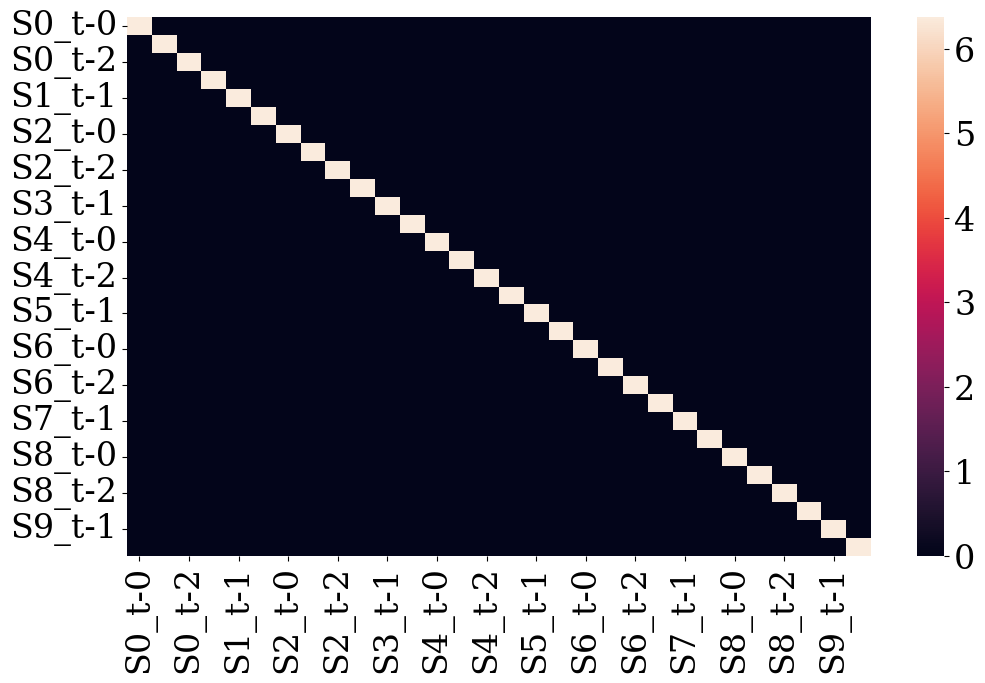

In [100]:
sns.heatmap(MI);

## Scoring

In [97]:
from pyEDM import EmbedDimension, Embed, MakeBlock


best_emb_mapping = dict.fromkeys(S.columns, 0)
for col in S.columns.values:
    for trg in S.columns.values:
        if col == trg:
            continue
            
        emb_to_rho = EmbedDimension(
            S,
            columns=col,
            target=trg,
            maxE=7,
            embedded=False,
            lib='1 4500',
            pred='4501 5000',
            showPlot=False
        )
        emb_to_rho = emb_to_rho.round(3)
        best_emb_dim = emb_to_rho.loc[emb_to_rho['rho'].argmax(), 'E']
        best_emb_mapping[col] += best_emb_dim

    best_emb_mapping[col] = int(round(best_emb_mapping[col] / len(best_emb_mapping)))

In [98]:
best_emb_mapping

{'S0': 3,
 'S1': 3,
 'S2': 3,
 'S3': 3,
 'S4': 4,
 'S5': 3,
 'S6': 3,
 'S7': 4,
 'S8': 3,
 'S9': 3}

In [44]:
def prf1(pred, true):
    TP = len(set(pred.edges) & set(true.edges))
    FP = len(set(pred.edges) - set(true.edges))
    FN = len(set(true.edges) - set(pred.edges))
    prec = TP/(TP+FP) if TP+FP else 0.
    rec  = TP/(TP+FN) if TP+FN else 0.
    f1   = 2*prec*rec/(prec+rec) if prec+rec else 0.
    return prec, rec, f1


def shd(pred, true):
    undirected_diff = set(map(frozenset, pred.edges)) ^ set(map(frozenset, true.edges))
    misdir = set(pred.edges) & set((v,u) for u,v in true.edges)
    return len(undirected_diff) + len(misdir)

In [46]:
for name, G_hat in {"PCMCI": G_pcmci, "PC": pc_graph}.items():
    p,r,f = prf1(G_hat, G_true)
    print(f"{name:<6}  PR={p:5.3f}  RC={r:5.3f}  F1={f:5.3f}  SHD={shd(G_hat,G_true)}")

PCMCI   PR=0.182  RC=0.990  F1=0.307  SHD=279
PC      PR=0.673  RC=0.706  F1=0.689  SHD=40


For the dataset MAGIC-IRRI PC algorithm works fine


Great. I’ll write a PhD-level academic review of causal identification methods focused on DAG-based frameworks. The review will emphasize mathematical formulations, algorithmic complexity, assumptions (e.g., faithfulness, causal sufficiency), and classification (e.g., score-based, constraint-based, hybrid). It will include BibTeX-style citations.

I’ll let you know once the review is ready.

# Causal Identification in DAG-based Frameworks: A Review

## Introduction  
Causal discovery seeks to infer cause-effect relationships from data by leveraging assumptions encoded in directed acyclic graphs (DAGs). A **DAG-based causal framework** represents variables as nodes and causal influences as directed edges, providing a graphical model for the data-generating process ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can)) ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=Several%20DAGs%20can%20describe%20exactly,a%20partially%20directed%20acyclic%20graph)). Unlike purely associative models, DAGs capture *structural* information: missing edges imply conditional independence, and directed paths encode causal ordering. **Causal identification** refers to determining causal structure or effects from observational data under appropriate assumptions. This review surveys major DAG-based causal identification methods, analyzing their mathematical foundations, computational complexity, algorithmic type (constraint-based, score-based, hybrid, etc.), assumptions (e.g. Markov and faithfulness conditions), and key invariance properties. We cover classical algorithms (PC, FCI, GES), recent advances (GSP, NOTEARS, ICP), and others, highlighting how each balances identifiability and practical estimation. We also distinguish *identifiability* (what can be determined in principle from infinite data and assumptions) from *estimation* (what is learned from finite samples). Throughout, we use formal definitions and representative formulas to ensure rigor, and we cite foundational works such as Pearl’s *do*-calculus for causal effects ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can)), Spirtes et al.’s constraint-based discovery algorithms, and Peters et al.’s contributions on invariance and causal inference.

## Preliminaries: Causal DAGs and Assumptions  
**Causal DAGs:** A DAG $G=(V,E)$ consists of nodes $V=\{X_1,\dots,X_d\}$ and directed edges $E$ with no cycles. Each node $X_i$ has a set of parents $\text{Pa}_i$ (its direct causes in the graph). A causal DAG can be associated with a Structural Equation Model (SEM) where each variable is a function of its parents plus an independent noise: 
$$X_i = f_i(\text{Pa}_i) + \varepsilon_i,$$ 
with $\varepsilon_i$ noise terms (assumed independent). The **causal Markov condition** holds: each variable is independent of its non-descendants given its parents ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=Markov%20Condition%20%26%20Faithfulness%20Assumption,specified%20by%20the%20Markov%20condition)) ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=%E2%80%A2%20Implication%3A%20faithfulness%20is%20assumed,the%20learned%20graph%20is%20correct)). Formally, for every $X_i$, 
$$X_i \perp\!\!\!\perp \text{NonDescendants}(X_i) \mid \text{Pa}_i,$$ 
which implies a set of conditional independence (CI) relations in any distribution that factorizes according to DAG $G$ ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can)). These CI relations can be read from $G$ via **d-separation** (Pearl, 2000). If a set $S$ of nodes d-separates $X$ and $Y$ in $G$, then $X \perp\!\!\!\perp Y \mid S$ in every distribution that respects $G$ ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can)). 

**Markov Equivalence and Identifiability:** Multiple DAGs can encode the same CI relations. Such DAGs are **Markov equivalent** and form an equivalence class, often represented by a completed partially directed acyclic graph (CPDAG) ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=Several%20DAGs%20can%20describe%20exactly,a%20partially%20directed%20acyclic%20graph)). All DAGs in a Markov equivalence class share the same skeleton (undirected structure) and the same v-structures (induced colliders). This fundamental ambiguity implies that **observational data alone (with only CI tests) can at best identify an equivalence class of DAGs**, not a unique DAG, unless further assumptions are made. In particular, without additional assumptions or interventions, causal structure is only *partially identifiable*: one can recover invariant features (like the CPDAG) but not distinguish DAGs within the same class. Key additional assumptions can improve identifiability, as discussed below.

**Causal Sufficiency:** A standard assumption is that the observed set of variables is *causally sufficient*, meaning there are no unobserved confounders (common causes) among them ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=)). Under causal sufficiency, every d-separation in the true DAG corresponds to an observable conditional independence in the data. If this fails (latent variables exist), specialized algorithms (e.g. FCI) are needed to correctly identify causal relations. We will highlight which methods assume causal sufficiency and which relax it.

**Faithfulness:** Another crucial assumption is **faithfulness**, which posits that the only conditional independencies in the data are those implied by the DAG’s d-separation; i.e. no cancellations or coincidences lead to spurious independencies ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=according%20to%20G,separation)). Formally, a distribution $P$ is faithful to DAG $G$ if for every disjoint sets $X, Y, S$: 
$$X \perp\!\!\!\perp Y \mid S \implies X \text{ and } Y \text{ are d-separated by } S \text{ in } G,$$ 
and vice versa ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=according%20to%20G,separation)). Faithfulness is stronger than the Markov condition and essentially ensures a one-to-one correspondence between graphical d-separations and true independencies. Nearly all constraint-based methods (and many score-based ones) require faithfulness (or variants like *restricted-faithfulness*) to be consistent ([](https://pages.stat.wisc.edu/~raskutti/publication/SPAlgorithm.pdf#:~:text=independence%20testing,SP%29%20algorithm%20are)). If faithfulness holds and we have infinite data (an “independence oracle”), the DAG’s Markov equivalence class is identifiable from observational data (Spirtes et al., 2000). Violations of faithfulness (e.g. nearly canceling paths) can degrade algorithms’ performance ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=whether%20their%20inferences%20can%20be,short%2C%20and%20can%20be%20violated)) ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=Many%20algorithms%20for%20causal%20inference,violations%20of%20faithfulness)), a point we revisit when discussing robust methods like GSP.

**Identifiability vs. Estimation:** It is important to distinguish theoretical identifiability from practical estimation. **Identifiability** means that a causal quantity (structure or effect) is *in principle uniquely determined* by the population distribution under given assumptions. For example, with faithfulness, the CPDAG of the true DAG is identifiable from an infinite sample of the joint distribution. Likewise, a causal effect $P(Y\mid do(X))$ is *identifiable* from observational data if it can be expressed in terms of the observed distribution (Pearl’s *do*-calculus provides criteria for this ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can))). By contrast, **estimation** refers to the finite-sample procedure of inferring these quantities from data, which involves statistical uncertainty, search heuristics, and error control. An algorithm can be *consistent* (converging to the correct structure as sample size grows) even if finite-sample estimates might be wrong due to noise. Throughout the review, we note when a method is provably consistent (usually under faithfulness and sufficiency) and how it handles the gap between infinite-data identifiability and finite-data estimation (e.g. through scoring penalties or conservative tests).

## Constraint-Based Algorithms

Constraint-based causal discovery algorithms infer the graph structure by testing conditional independence constraints implied by the causal Markov and faithfulness assumptions. They typically have two phases: (1) **Skeleton identification** – determine which pairs of variables are adjacent in the graph by finding a separating set $S$ such that $X \perp\!\!\!\perp Y \mid S$ for each non-adjacent pair $(X,Y)$. (2) **Edge orientation** – orient the undirected skeleton into a DAG (or pattern) by identifying v-structures and applying logical orientation rules. The output is a graph (often a CPDAG or a partial ancestral graph) that represents the Markov equivalence class of the causal model consistent with the observed independencies.

### PC Algorithm (Peter–Clark Algorithm)  
The **PC algorithm** (named after its authors Peter Spirtes and Clark Glymour) is a prototypical constraint-based method ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=Many%20algorithms%20for%20causal%20inference,violations%20of%20faithfulness)). PC assumes causal sufficiency and faithfulness. It starts with a complete undirected graph on all $n$ variables and proceeds to remove edges that are rejected by conditional independence (CI) tests ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=FCI%20constructs%20a%20causal%20graph,in%20detail%20elsewhere9%20%2C%2036)). In detail, PC performs CI tests in increasing order of conditioning set size: first remove edges for marginal independencies, then for conditional independencies given one variable, then two, etc. ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=algorithm%20consists%20of%20three%20steps,subset%20S%20of%20the%20remaining)). When an edge $X\text{---}Y$ is removed, the conditioning set that led to independence is recorded as a separating set for $(X,Y)$. After obtaining a skeleton (undirected graph) with no spurious edges, PC identifies **unshielded triples** (configurations $X - Z - Y$ where $X$ and $Y$ are not directly connected) and orients $X \rightarrow Z \leftarrow Y$ if $Z$ was not in the separating set of $X$ and $Y$. Such oriented triples are *v-structures* (colliders) and are guaranteed by faithfulness to be present in the true DAG ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=d,same%20as%20those%20that%20can)). Finally, PC applies a series of orientation propagation rules (e.g. arrow propagation, avoiding cycles or new v-structures) to direct as many remaining edges as possible without contradicting earlier results (Spirtes et al., 2000). The output of PC is a CPDAG representing the equivalence class of DAGs consistent with the tests.

*Mathematical Properties:* Under the assumptions of causal Markov, acyclicity, causal sufficiency, and faithfulness, the PC algorithm is **sound and complete**: given perfect CI information, it will recover the true Markov equivalence class (the correct skeleton and v-structures) ([[PDF] Order-Independent Constraint-Based Causal Structure Learning](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=Learning%20jmlr.org%20%20The%20PC,be%20faithful%20to%20a)). In the large-sample limit, with an asymptotically valid CI test, PC is **consistent** (Spirtes et al., 2000), meaning the probability that PC outputs the true CPDAG approaches 1 as sample size $\to\infty$. However, if the distribution nearly violates faithfulness (almost independencies), PC’s decisions can become unreliable, motivating variants like the “Conservative PC” (CPC) algorithm that avoids overconfident orientations in such cases.

*Complexity:* A key drawback of PC is its computational complexity. In the worst case (a fully connected graph), PC may need to test independence for conditioning sets up to size $n-2$, which is combinatorially many. The worst-case time complexity is super-exponential in $n$ (NP-hard in general). However, complexity can be parameterized by the graph’s maximum degree $k$: the number of CI tests grows roughly as $O(n^{k})$ ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=Complexity%20%E2%80%A2%20The%20complexity%20of,case%20running%20time%20of)) (exponential in $k$ but polynomial in $n$ if $k$ is moderate). In practice, if the true graph is sparse, PC is feasible; for dense graphs, PC becomes very slow. There are improvements like parallel PC and order-independent PC (PC-stable) to address variable ordering effects and efficiency ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=%E2%80%A2%20PC%20algorithm%20has%20a,case%20running%20time%20of)) ([CSCE580 GuestLecture1 -- BNLearning](https://pooyanjamshidi.github.io/csce580/lectures/CSCE580-GuestLecture--BNLearning.pdf#:~:text=Complexity%20%E2%80%A2%20The%20complexity%20of,case%20running%20time%20of)).

*Assumptions:* **Type:** Constraint-based. **Required assumptions:** (i) *Causal Markov* and *Faithfulness* – ensures a one-to-one link between separations in the DAG and independencies in data ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=according%20to%20G,separation)). (ii) *Causal Sufficiency* – no hidden confounders; violations require using algorithms like FCI instead. (iii) Typically assumes i.i.d. sampling and possibly general position (no exact cancelling of independencies beyond faithfulness). **Key invariances:** Under these assumptions, the CI relations used by PC are *invariant properties of the underlying causal DAG*. In particular, if the distribution changes by interventions on other variables but the causal structure remains, those invariances (independencies) would persist. The PC algorithm’s output (a CPDAG) thus represents all DAGs that share the same invariant independence structure. PC is also known to have an order-dependence issue (the result can depend on the order in which variables are considered for testing), which is remedied by the *PC-stable* modification ensuring invariance under variable ordering.

- **Type:** Constraint-based structure learning (CI testing).  
- **Complexity:** Worst-case $O(n^{k})$ CI tests (exponential in max degree $k$); polynomial time for sparse graphs; typically exponential in general.  
- **Assumptions:** Causal sufficiency (no latent confounders); Causal Markov condition; Faithfulness (or a variant, e.g. strong-faithfulness) ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=according%20to%20G,separation)); i.i.d. data.  
- **Invariances:** Leverages invariant conditional independencies implied by the DAG. Identifies the Markov equivalence class (invariant under rotations within that class). Output is a CPDAG capturing all invariant causal features (e.g. v-structures) shared by equivalent DAGs.

### Fast Causal Inference (FCI) Algorithm  
The **FCI algorithm** (Spirtes et al., 1995; Richardson & Spirtes, 2002) extends the PC approach to relax the causal sufficiency assumption. FCI can handle hidden variables (latent confounders) and even selection bias (in a general version called *Selection-Biased FCI*). The output of FCI is not a DAG or CPDAG, but a **Partial Ancestral Graph (PAG)**, which represents an equivalence class of DAGs *with latent variables and/or selection bias*. Edges in a PAG can be directed ($\to$), bidirected ($\leftrightarrow$, indicating the presence of a latent confounder between two nodes), or partially oriented (marked with a circle $\circ$ at one end to denote ambiguity). The PAG encodes conditional independence relations of a **maximally extended DAG model** (allowing latent variables) that fits the data.

*How FCI works:* FCI’s first phase mirrors PC’s skeleton identification but uses a broader notion of separation (called m-separation in an augmented graph) appropriate for latent variable models ([Comparison of strategies for scalable causal discovery of latent ...](https://pmc.ncbi.nlm.nih.gov/articles/PMC6096780/#:~:text=The%20standard%20constraint,However%2C%20the%20word)). Starting from a complete graph on observed variables, FCI removes edges by testing conditional independencies just like PC, but it must consider that an independence could be due to a path blocked by an unobserved confounder. After obtaining an initial skeleton among observed variables, FCI enters a more complex orientation phase. It first orients obvious colliders (unshielded triples $X\circ\!\!-\!\!\circ Z \circ\!\!-\!\!\circ Y$ where $Z$ was not in the separating set for $X$ and $Y$, so $X \to Z \leftarrow Y$). Next, a series of rules (called *orientation rules* R1–R10 in the literature) propagate directions taking into account the possibility of latent variables. For example, if $X - Y$ remains undirected but $X$ is d-separated from $Y$ by some set that does **not** include one of them, then that edge is covered by a latent structure and is marked with $\leftrightarrow$. The logic is intricate but ensures that if an edge cannot be oriented definitively as $X\to Y$ or $Y\to X$, it remains ambiguous (circle ends). The final PAG encodes all invariant causal features discernible despite latent confounding. Notably, FCI can discover the existence of a latent common cause (by producing a bidirected $X \leftrightarrow Y$) even though neither the latent nor the exact causal direction between $X$ and $Y$ is identified.

*Complexity:* FCI has similar complexity to PC in terms of the order of CI tests (also exponential in worst case). Each CI test in FCI is analogous to PC’s, though the conditioning sets considered can be larger due to the presence of possible latent structures. The additional orientation rules add polynomial overhead. In practice, FCI is slower than PC on the same number of variables, but still polynomial for bounded-degree graphs ([](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf#:~:text=FCI%2C%20in%20the%20sense%20that,but%20is%20slightly%20less)). There is also a “Really Fast Causal Inference” (RFCI) variant that simplifies some tests to improve speed at the cost of some ambiguity in the output.

*Assumptions:* **Type:** Constraint-based (with extended independence tests for hidden variables). **Assumptions:** Causal Markov and faithfulness still hold but in the sense of a maximal ancestral graph (MAG) which accounts for latents. No assumptions of causal sufficiency – FCI explicitly allows latent confounders and selection bias (if using a further generalized FCI). Still assumes no cycles (DAG underlying), and typically assumes the distribution is *semi-faithful* (no independencies beyond those implied by some DAG with latents). **Key invariances:** FCI leverages the fact that even with unobserved confounders, certain conditional independencies are invariant and can be detected. For example, if $U$ is an unobserved cause of $X$ and $Y$, then $X$ and $Y$ will be marginally dependent but conditionally independent given any variable that “separates” the path (like a collider on that path). FCI finds invariant features like “Y-structures” (a pattern indicating no confounding on a collider) ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=Other%20than%20the%20searching%20strategies,it%20encounters%20a%20%E2%80%9CY%E2%80%9D%20structure17)). The PAG output by FCI represents all causally compatible models, so any edge oriented as $X\to Y$ in the PAG means *in every DAG with some latents that fits the data, $X$ is an ancestor of $Y$*. This invariance makes FCI powerful: it only commits to causal directions that are reliably identified even in presence of hidden variables ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=Other%20than%20the%20searching%20strategies,it%20encounters%20a%20%E2%80%9CY%E2%80%9D%20structure17)).

- **Type:** Constraint-based (latent-variable-capable).  
- **Complexity:** Similar order to PC (exponential in high connectivity); often slower due to more complex orientation rules.  
- **Assumptions:** No causal sufficiency needed (handles hidden variables); requires extended faithfulness (no unaccounted independencies) and causal Markov for a DAG with possibly hidden nodes; acyclicity and no selection bias (unless extended FCI with bias handling).  
- **Invariances:** Identifies structural features invariant under unobserved confounding. Independence and separation are considered in a MAG/PAG context. The output PAG encodes equivalence classes of DAGs with latents that share the same invariant independencies.

## Score-Based Algorithms

Score-based methods approach causal discovery as an optimization problem. They define a **score** (usually related to the goodness-of-fit of a DAG to data, penalized for complexity) and then search for the DAG structure that maximizes this score. Typically, the score is a log-likelihood (or marginal likelihood) of the data under a Bayesian network model given the DAG, combined with a penalty to avoid overfitting (e.g. BIC or MDL penalty). Unlike constraint-based methods that rely on local CI decisions, score-based algorithms consider global model fit. They implicitly encode the Markov condition in the scoring function: a candidate DAG $G$ gets a high score if it can describe the joint distribution efficiently. A major advantage is the ability to incorporate **soft** measures of trade-off (via the score) and handle statistical uncertainty more naturally. However, the search space of DAGs is super-exponential in $n$, so algorithms must employ heuristics (greedy search, dynamic programming, MCMC, etc.) since exact optimization is NP-hard.

### Greedy Equivalence Search (GES)  
**GES** (Greedy Equivalence Search) is a classic score-based algorithm introduced by Chickering (2002). It searches through the space of DAG *equivalence classes* (represented as CPDAGs) by adding or removing edges in a greedy hill-climbing fashion to optimize a score (typically BIC score). GES consists of two phases ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=,algorithm)): a **forward phase** that starts from an empty graph and greedily adds the edge that most increases the score (maximizes data likelihood with penalty) until no addition improves the score; and a **backward phase** that starts from the result of forward phase and greedily removes an edge that most improves the score (usually, further increases BIC by removing unnecessary connections) until no removal improves it. This forward-backward strategy aims to find a local optimum of the score that is a good approximation to the true structure. Importantly, each addition or removal is actually performed on the current *equivalence class* (CPDAG) rather than a specific DAG, ensuring that GES respects the score equivalence property (two DAGs in the same Markov equivalence class have the same score, given certain scoring criteria like BIC or BDeu). Thus, GES moves among equivalence classes with guaranteed score improvement and outputs a CPDAG as the final result.

*Theoretical properties:* GES is proven to be **asymptotically consistent** under standard assumptions (Chickering, 2002). If the data distribution is generated by a DAG $G^*$ that satisfies the score’s assumptions (e.g. a joint Gaussian or multinomial distribution for BIC) and if the scoring criterion is *score-equivalent* and *consistent*, then in the limit of infinite data, GES will find the true equivalence class $G^*$ (more precisely, a global optimum of the score which corresponds to $G^*$). The score-equivalence means if two DAGs are Markov equivalent, they have the same score (BIC and Bayesian scores have this property), allowing the search to be well-defined on equivalence classes. GES is also *complete* in the sense that its forward-backward greedy strategy can reach the global optimum (it’s an **inclusion optimal** algorithm: adding all true edges then removing false ones can achieve the true structure (Meek, 1997; Chickering, 2002)). However, the greedy nature means in finite samples it might get stuck in a local optimum that is not global, although in practice using equivalence classes mitigates some local traps.

*Complexity:* The worst-case time complexity of naive GES is super-exponential since the space is huge. But heuristically, each step of adding or removing tests a number of candidate edges polynomial in $n$ (checking score deltas for each possible edge addition or removal). The number of steps can be large, but in many cases GES is faster than PC for moderate $n$ because it doesn’t explicitly test high-order conditional independencies — instead, it fits local scores. In high-dimensional settings, an optimized version called FGES (Fast GES) uses clever data structures and parallelization to handle thousands of variables ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=,algorithm)). FGES maintains the same theoretical output as GES but scales better in practice.

*Assumptions:* **Type:** Score-based (greedy search in model space). **Assumptions:** (i) The data are generated by a DAG model within the considered class (usually discrete or Gaussian BN). (ii) Causal sufficiency (no latents) is assumed by vanilla GES, as hidden confounders would violate the DAG model’s assumptions (though extensions exist to handle latent structure by scoring e.g. maximal DAGs or using specially designed scores). (iii) The true distribution satisfies the *faithfulness* or *noise-free* assumption implicitly, so that the highest-scoring DAG corresponds to the true causal structure (no parameter degeneracies that make a wrong structure fit as well). (iv) Score equivalence: the scoring function should not prefer one DAG over an equivalent DAG, which holds for many standard choices (BIC, BDe). **Key invariances:** GES relies on *likelihood score invariances*: all DAGs in the same Markov equivalence class will (in the large sample limit) have equal scores if the score is truly score-equivalent. Therefore, the greedy search in equivalence class space is valid. Moreover, like constraint methods, GES will always identify correct v-structures under infinite data (because only the true orientation yields a better score due to likelihood being higher for the collider than for either causal chain) ([Challenges and Opportunities with Causal Discovery Algorithms: Application to Alzheimer’s Pathophysiology | Scientific Reports](https://www.nature.com/articles/s41598-020-59669-x#:~:text=the%20BIC,higher%20likelihood%20than%20other%20structures)). In fact, GES typically orients colliders correctly because a v-structure (A→C←B) allows a better fit than a chain (A→C→B) when both A and B influence C independently. Another invariance is that GES’s result does not depend on the variable ordering (it searches globally). However, it *does* depend on the chosen score; if the score is misspecified, the output can be incorrect despite data.

- **Type:** Score-based (greedy hill-climbing in DAG space using BIC/score).  
- **Complexity:** NP-hard in theory; greedy heuristic with forward-backward phases. Each step requires evaluating score change for $O(n^2)$ candidate edge operations; often efficient in practice for tens to low-hundreds of variables (FGES scales to larger $n$ with parallelism).  
- **Assumptions:** Causal sufficiency (no hidden variables); data follows a parametric model (e.g. linear Gaussian or discrete) that matches scoring assumptions; faithfulness (so the true causal DAG maximizes the chosen score); large sample or appropriate penalty to avoid overfitting.  
- **Invariances:** Score-equivalence (score depends only on equivalence class structure, not arbitrary orientation of immorality-free edges); invariance of v-structures detection via score; produces a CPDAG capturing invariant causal features as in constraint methods.

### Greedy Sparsest Permutation (GSP)  
The **Greedy Sparsest Permutation (GSP)** is a more recent algorithm that combines elements of score-based search with constraint-based rationale by searching over variable orderings (permutations) to find a minimal causal model. The idea, introduced by Solus et al. (2017) and further developed by Raskutti & Uhler (2018), is that if one can find an ordering of variables such that each variable has only a few predecessors as parents, then one has effectively identified a sparse DAG that fits the data. **Sparsest Permutation (SP)** algorithms consider *all permutations* of variables and select the DAG (consistent with each permutation) that has the fewest edges consistent with the observed conditional independencies. Since searching all permutations ($n!$ possibilities) is infeasible for even moderate $n$, GSP is a greedy heuristic that incrementally builds a permutation aiming to keep the graph sparse ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=might%20be%20improved%20by%20relaxing,that%20if%20the%20data%20generating)).

*Mechanism:* GSP works by iteratively inserting variables into an ordering and assigning parents from those earlier in the order such that adding an edge explains dependencies (typically using CI tests to decide if an edge is needed). In essence, for a given order $\pi$, one can determine an optimal DAG by letting each node have as parents **all** earlier nodes in $\pi$ that are not independent of it conditional on some subset (this is akin to the algorithm of Verma & Pearl (1990) for minimal I-maps). The total number of edges for that DAG is then minimized when each variable’s parents are the minimal set explaining its dependencies. GSP attempts to find the permutation that yields the least total number of edges (hence “sparsest”). It uses greedy local swaps or other local moves in permutation space to improve an initial guess. Solus et al. (2021) propose operations like *swap* and *tuck* to efficiently traverse permutation space and find a good candidate ordering ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=directed%20acyclic%20causal%20models%2C%20including,art%20causal%20search)).

The motivation behind GSP is to weaken the faithfulness requirement: instead of requiring that *all* conditional independencies are captured (which can fail in nearly-unfaithful cases), one seeks a model with minimal complexity (edges) that still explains the major independencies. In fact, GSP and related permutation methods require a strictly weaker assumption than faithfulness, often called *ordered connectivity* or *adjacency-faithfulness*, which essentially means no false edges are needed to explain independencies ([](https://pages.stat.wisc.edu/~raskutti/publication/SPAlgorithm.pdf#:~:text=independence%20testing,SP%29%20algorithm%20are)). Raskutti and Uhler (2018) proved that if the true distribution satisfies a certain graphoid property and a mild assumption (called *stable sparseness*), the sparsest permutation will yield the correct Markov equivalence class with high probability ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=might%20be%20improved%20by%20relaxing,that%20if%20the%20data%20generating)) ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=distribution%20is%20a%20graphoid%2C%20then,super%20exponential%20in%20the%20number)). Thus, GSP can be consistent under weaker conditions than PC, addressing some cases where PC fails due to nearly violated faithfulness ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=whether%20their%20inferences%20can%20be,short%2C%20and%20can%20be%20violated)).

*Complexity:* Exhaustive search over permutations is $O(n!)$, but GSP’s greedy relaxations make it manageable. Each step of evaluating a candidate permutation’s score (number of edges or a score function) requires checking parent sets for each node (which can be done in polynomial time if using conditional independence tests or a decomposable score). The overall complexity is not rigorously polynomial – it depends on how many permutations the greedy procedure explores. Empirically, GSP and its relaxations (like GRaSP) have shown good performance up to $n \approx 100$ or more, especially for dense graphs where PC/GES struggle ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=and%20develop%20a%20class%20of,1%20INTRODUCTION)) ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=consistent%20under%20increasingly%20weaker%20assumptions,for%20dense%20graphs%20and%20graphs)). It remains a heuristic without a worst-case guarantee better than brute force, but it often finds a very sparse candidate early, pruning much of the search.

*Assumptions:* **Type:** Hybrid (permutation-based search using both independence tests and a sparsity score). It’s not purely score-based in the likelihood sense, but it is an optimization over an objective (minimize edges) subject to fitting independence constraints, thus combining both paradigms. **Assumptions:** Requires the causal Markov condition. Does not require full faithfulness; instead uses a weaker condition that there is a unique minimal DAG explaining the independencies (no indistinguishable alternatives with equal sparsity). It assumes causal sufficiency (no latents) in its basic form (like PC). It can incorporate CI tests, so distribution-free in principle except needing an independence oracle. **Key invariances:** GSP exploits the invariance that in the true causal order, each variable is independent of all non-descendants that come after it. If one guesses the correct ordering (topological sort of the DAG), then for each variable $X_i$, any variable that comes after $X_i$ in the order is either its descendant or independent of it given some earlier variables. The true ordering will yield a very *sparse* connectivity pattern (each node only connects to earlier ones that are its causes). This sparsity is an invariant property of the true causal order. GSP’s edge decisions are based on conditional independencies which are invariant; by prioritizing fewer edges, it seeks an invariant minimal representation. GSP is also robust to certain unfaithful configurations since it won’t add two canceling edges if one edge can suffice to explain the dependency pattern.

- **Type:** Hybrid/permutation-based (combines CI testing with a combinatorial sparsity search).  
- **Complexity:** Greedy heuristic over $n!$ search space; in practice polynomial-time per permutation evaluation, but overall runtime can grow quickly with $n$. Works well with $n$ up to hundreds with optimized moves (GRaSP).  
- **Assumptions:** Markov condition; adjacency-faithfulness or similar (weaker than full faithfulness) ([](https://proceedings.mlr.press/v180/lam22a/lam22a.pdf#:~:text=might%20be%20improved%20by%20relaxing,that%20if%20the%20data%20generating)); no latent confounders (or extend MAG concept); typically assumes a dense enough sampling of distribution to reliably test CI.  
- **Invariances:** Leverages the invariant ordering of causes before effects. Minimal edge count is used as a proxy for the true ordering’s property. Independence relationships (separators) are invariant and used to include/exclude edges. Returns a CPDAG (or a set of sparse DAGs) that represents invariant causal connections under the identified ordering.

## Invariance-Based Methods

A different approach to causal discovery is to exploit *invariance properties* of causal mechanisms across different environments or subsets of data. These methods go beyond single-distribution observational data, instead leveraging heterogeneity (from experiments or nature) to identify causality.

### Invariant Causal Prediction (ICP)  
**Invariant Causal Prediction (ICP)** is an approach introduced by Peters, Bühlmann, and Meinshausen (2016) that identifies causal relationships by leveraging the invariance of causal mechanisms across multiple environments. Assume we observe data from a set of environments (or experimental conditions) $E = \{1,2,\dots,m\}$ – for example, different experimental settings, subsets of data where certain variables may be intervened on, or different subpopulations. The *core idea* of ICP is that if a variable $X_j$ is a direct cause of an outcome $Y$, then the conditional distribution $P(Y \mid X_j)$ (or more generally $P(Y \mid \text{Parents}_Y)$) remains the same across all environments **as long as $X_j$ is not itself intervened on**. Causal predictors have *invariant* relationships with the target, whereas spurious associations may change when background conditions change.

ICP formalizes this by testing invariances: one considers a subset $S \subseteq \{X_1,\dots,X_{d}\}$ of predictors and asks, “Is the conditional law of $Y$ given $S$ the same in all environments?” If yes, $S$ is a candidate set of causal parents of $Y$. In practice (for continuous data), one often performs a regression of $Y$ on $S$ pooling all environments and then checks if the regression residuals have equal distribution (or at least equal expectation) across environments. Formally, for each environment $e$, let $Y = g_S^e(S) + \varepsilon^e$ be a predictive model. $S$ is *invariant* if one can find a model such that $g_S^1 = g_S^2 = \cdots = g_S^m$ (the relationship does not change with $e$) and the residual $\varepsilon$ distribution is identical across $e$. Under mild assumptions, the intersection of all such invariant sets contains the true direct causes of $Y$ (with high probability) (Peters et al., 2016). One typically takes the *intersection* of all subsets found to be invariant – this yields a set $\hat{S}$ which is a consistent estimator of $\text{Pa}_Y$ (direct causes of $Y$), even in presence of other (possibly hidden) variables.

ICP is not a full structure discovery method for all variables at once; rather it focuses on identifying causes of a given target $Y$. Repeating ICP for each variable as target could in principle recover the whole graph, though with high computational cost. The strength of ICP is that it does not require faithfulness in the same way as PC/GES since it uses environmental changes as a proxy for interventions. It does assume that the set of environments is rich enough that at least one environment changes the distribution of non-causes while leaving the causal mechanism of $Y$ intact (this is sometimes called *Independent Causal Mechanisms* and *modularity*: causal modules do not change unless directly intervened upon).

*Complexity:* Checking all subsets $S$ of predictors for invariance is combinatorial ($2^{d}$ subsets). In practice, ICP can be implemented with a forward-selection or other search strategy to avoid brute force. The method is most feasible when the true parent set of $Y$ is not too large, or one can restrict the search (e.g. using domain knowledge). For moderate $d$ (tens of variables) or focusing on a specific target, ICP is tractable. Recent advances (heuristics and more efficient tests) have extended ICP ideas to larger scales and to non-linear models.

*Assumptions:* **Type:** Invariance-based (uses multiple environments; essentially a form of constraint-based across datasets). **Assumptions:** (i) *Causal invariance:* The conditional distribution of $Y$ given its true parents $\text{Pa}_Y$ is invariant across environments (no matter which environment, if we condition on the actual causes of $Y$, the distribution of $Y$ is the same). (ii) In each environment, the set of variables that might have changed (e.g. whose mechanism or distribution is different) does not include $Y$’s causal mechanism itself. This is like saying environments act like interventions on some variables other than $Y$ (or on $Y$’s parents perhaps), but *not* directly on $Y$ in a way that changes $Y$’s response to its causes. (iii) i.i.d. samples within each environment; enough data per environment to test for distributional equality. ICP does **not** require causal sufficiency – it can handle hidden common causes because those would typically violate invariance if they were influencing $Y$ (the method’s consistency proofs account for potential confounders by showing that only true parents give full invariance). It also does not require faithfulness in terms of independencies; instead it requires a form of *stability/transportability* of mechanisms.

**Key invariances:** By design, the invariance of $P(Y \mid S)$ across environments is the criterion. If $S$ includes all true parents of $Y$, then indeed $P(Y \mid S)$ remains the same even if other variables or external conditions change, because $S$ “shield” $Y$ from those changes. If $S$ is missing one of $Y$’s parents, then when that missing parent’s distribution changes across environments, the distribution of $Y$ given $S$ will also change (detectably) – thus $S$ fails the test. If $S$ contains an extraneous variable that is not a parent, that variable’s relationship with $Y$ might not remain invariant when conditions change (it could create a false dependency that varies). Therefore, the true parent set is the unique set (under appropriate conditions) that yields perfect invariance. This approach is robust to certain confounders: even if some $Z$ confounds $X$ and $Y$, unless $Z$ also confounds the relationship in all environments, the set $\{X\}$ might fail invariance (if $X$ is not true cause). In summary, **invariance across environments is used as a signature of causality**. This principle is closely related to the concept of *autonomy of causal mechanisms* in Pearl’s framework and has connections to causal transfer learning and robustness (Schölkopf et al., 2021).

- **Type:** Invariance-based, multi-environment (neither purely score nor purely single-distribution constraint).  
- **Complexity:** Combinatorial subset search (exponential in worst case), but feasible for moderate targets or guided search.  
- **Assumptions:** Existence of multiple environments (experimental or observational perturbations); causal mechanism for $Y$ is invariant; no direct intervention on $Y$ across environments; enough data to test equality of conditional distributions. Does not assume faithfulness or sufficiency explicitly.  
- **Invariances:** Identifies features (parent sets) whose predictive relationship to $Y$ is invariant across environment changes. Causal parent-child relationships are stable (module unchanged) under interventions on other parts of the system – this is the invariance leveraged. 

## Continuous Optimization Methods

With advances in machine learning, a new class of causal discovery methods formulates structure learning as a continuous optimization problem. These methods encode the acyclicity constraint with a differentiable penalty or constraint and then optimize a loss (usually based on reconstruction error or likelihood) over real-valued adjacency matrices. They effectively turn the combinatorial search over DAGs into a continuous parameter estimation problem.

### NOTEARS (Non-combinatorial Optimization via Trace Exponential)  
**NOTEARS** (Zheng et al., 2018) is a seminal algorithm in this category. It considers a linear SEM: $X = XW + N$ where $W$ is a weighted adjacency matrix of the DAG and $N$ is a matrix of independent noise variables. The goal is to find a matrix $W$ that fits the data well (e.g. minimizes sum of squared errors $\|X - XW\|^2$) while enforcing that $W$ corresponds to a DAG (no cycles). To avoid the combinatorial DAG constraints, NOTEARS introduces a smooth function $h(W)$ that is zero if and only if $W$ is acyclic. Specifically, one formulation is:
$$ h(W) = \operatorname{tr}\!\Big(\exp(W \circ W)\Big) - d = 0, $$ 
where $W \circ W$ is the elementwise square and $\exp(\cdot)$ is the matrix exponential ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=Theorem%201,Moreover%2C%20h%28W%29%20has%20a)). This function $h(W)$ is a differentiable equality constraint; intuitively, $\operatorname{tr}(\exp(W \circ W))$ expands to $d +$ (sum of cycles weights). The equation $h(W)=0$ characterizes acyclic graphs ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=Theorem%201,Moreover%2C%20h%28W%29%20has%20a)). NOTEARS then solves the optimization:
$$ \min_{W \in \mathbb{R}^{d\times d}} F(W) \quad \text{s.t.} \quad h(W) = 0, $$
where $F(W)$ is a loss function, for example 
$$F(W) = \frac{1}{2n}\|X - XW\|_2^2 + \lambda \|W\|_1,$$ 
a least-squares with $\ell_1$ penalty to encourage sparsity (so it’s akin to fitting a sparse weighted adjacency matrix). This is solved with standard continuous optimization techniques (augmented Lagrangian, gradient-based optimizers) ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=learning%20of%20DAGs%20so%20that,with%20a%20smooth%20equality%20constraint)) ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=are%20only%20guaranteed%20to%20find,com%2Fxunzheng)). The result is a weight matrix $\hat{W}$ which is then thresholded to obtain a binary adjacency (structure).

*Advantages:* NOTEARS can efficiently handle fairly large graphs (e.g. $d=50$–100) by leveraging gradient-based methods and is easily extendable (the authors also did logistic regression for binary data, etc.). It finds both the structure and parameters simultaneously by solving a single optimization problem ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=G%202%20D%20in%20,quick%20illustration%20and%20Section%205)). One of the surprising findings was that **NOTEARS does not require the faithfulness assumption** in the same way constraint-based methods do – it can, for instance, recover correct DAGs even when the true distribution has near-zero partial correlations (a near-violation of faithfulness), as long as the exact optimum of the optimization corresponds to the true structure (which it will if the model class is correct) ([[PDF] Learning DAGs with Continuous Optimization Xun Zheng](https://www.ml.cmu.edu/research/phd-dissertation-pdfs/thesis-zheng-xun.pdf#:~:text=,does%20NOTEARS%20work%3F%20One)). In other words, by focusing on minimizing reconstruction error, NOTEARS bypasses the need for explicit CI tests that might fail when correlations are very small but nonzero. This makes it robust in scenarios where PC might misinterpret a tiny correlation as independence. 

*Complexity:* Each evaluation of $h(W)$ involves a matrix exponential, which can be computed in $O(d^3)$ time ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=A%20key%20conclusion%20from%20Theorem,appeared%20in%20the%20DAG%20learning)). Gradient-based optimization will require many such evaluations, but typically the number of iterations is manageable (tens to hundreds). Empirically, NOTEARS solves problems up to $d \approx 100$ in seconds to minutes on modern hardware. The overall complexity is difficult to characterize in Big-O because it depends on convergence of the solver (which is not worst-case guaranteed polynomial). In practice, it scales much better than combinatorial search for moderate $d$. For very large $d$ (hundreds+), the cubic scaling of the matrix exponential can be a bottleneck, but there are iterative and approximate methods to handle it. In summary, NOTEARS turns structure learning into solving a series of matrix operations and gradient steps, which is far more efficient than naive search, though the problem is still non-convex (so one must be careful about local minima).

*Assumptions:* **Type:** Continuous score-based optimization (with differentiable acyclicity constraint). **Assumptions:** The standard NOTEARS assumes a **linear SEM with additive noise** – essentially a linear Gaussian (or at least sub-Gaussian) model. The causal sufficiency assumption holds (no latent confounders) because a single $W$ is fit to all variables. It assumes the data truly follows a DAG structure (i.e. there exists some weighted acyclic $W$ generating the data). While it doesn’t explicitly require faithfulness, it does assume that the optimization problem has a unique minimum at the true $W$ (this can fail if two different DAGs produce exactly the same covariance, which is the faithfulness violation case; however in linear models that usually implies some parameter degeneracy which would mean the optimum is not unique). For identifiability, one often assumes either no degeneracies in $W$ or some additional condition to avoid flipping edges with equal error. In practice, a small $\ell_2$ weight on $W$ or thresholding helps ensure a stable solution. **Key invariances:** NOTEARS exploits the fact that in a correctly specified linear model, the independence structure is encoded in zero entries of $W$. It enforces acyclicity invariantly through $h(W)$. One might say the invariant here is the *acyclic constraint itself* and the minimality of the SEM: if an edge is not present in the true DAG, setting that entry of $W$ to zero should (in the optimum) not worsen the loss, whereas adding a nonzero weight where no true edge exists would only add spurious covariance that doesn’t help fit the data. Thus, the zero pattern of the optimal $W$ is an invariant indicator of the absence of causal links. Another invariance: because it’s optimizing a global score, NOTEARS by design yields a model that is as good as a full ML estimate for that structure, so it shares the likelihood invariances with score-based methods (i.e. it will correctly identify v-structures by the same mechanism of improved fit). Also, being essentially a parametric ML method, it inherits any invariances of the ML estimator (for example, in linear Gaussian models, the correct model is identifiable up to Markov equivalence; NOTEARS will output one member of the class, often the true DAG if there is any slight edge weights asymmetry to distinguish it).

- **Type:** Continuous optimization (score-based with equality constraint).  
- **Complexity:** Polynomial per iteration ($O(d^3)$ for matrix exponential); non-convex optimization but usually fast convergence for moderate $d$. Scales to tens or hundreds of variables.  
- **Assumptions:** Linear SEM (or specified differentiable model); no hidden confounders; noise independent and typically identical distribution; true DAG generates data (model correct); in practice, requires data sufficient to estimate covariance accurately. Does not strictly need global faithfulness, but relies on a unique optimum.  
- **Invariances:** Encodes the global acyclicity invariant via $h(W)=0$ ([DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://papers.neurips.cc/paper/8157-dags-with-no-tears-continuous-optimization-for-structure-learning.pdf#:~:text=Theorem%201,Moreover%2C%20h%28W%29%20has%20a)). Respects score-equivalence in the sense that the final loss depends only on the equivalence class (though optimization might pick one DAG). Captures invariant sparsity pattern of true $W$ (zero entries correspond to missing edges in all equivalent DAGs). The approach is robust to small perturbations in data relationships, focusing on overall fit.

## Other Notable Methods and Extensions  

Beyond the above, numerous other DAG-based causal discovery methods exist, often combining ideas or adding new assumptions for identifiability:

- **LiNGAM (Linear Non-Gaussian Acyclic Model):** Shimizu et al. (2006) showed that if the data follow a linear DAG model *but with non-Gaussian independent noises*, the causal DAG becomes *fully identifiable*, not just up to Markov equivalence ([[PDF] A Linear Non-Gaussian Acyclic Model for Causal Discovery](https://jmlr.org/papers/volume7/shimizu06a/shimizu06a.pdf#:~:text=How,2006)) ([A pooling-LiNGAM algorithm for effective connectivity analysis of ...](https://pmc.ncbi.nlm.nih.gov/articles/PMC4186480/#:~:text=The%20LiNGAM%20algorithm%20utilizes%20higher,2006)). The non-Gaussianity breaks the symmetry that plagues Gaussian DAGs. LiNGAM uses Independent Component Analysis (ICA) to exploit higher-order statistics: it finds an unmixing matrix that corresponds to the causal ordering. In brief, if $X = B X + N$ (with $N$ non-Gaussian, independent components), then one can recover $B$ (and hence the directed graph) by an ICA algorithm. LiNGAM is a **constraint-based** method in spirit (it finds an ordering such that variables become independent after appropriate subtraction of parent effects) but also uses a scoring (likelihood of independent components). It assumes no latent variables and that each variable is a linear mixture of its parents plus a non-Gaussian noise; under these assumptions it is provably consistent and can even determine the exact ordering of variables (not just CPDAG). Variants like DirectLiNGAM (Shimizu et al., 2011) improve computational efficiency.

- **Nonlinear Additive Noise Models (ANM):** Hoyer et al. (2009) extended LiNGAM to nonlinear relationships: if $Y = f(X) + N$ with $N$ independent of $X$, and both $f$ and distribution of $N$ are “generic” (no fine-tuned cancellation), one can often distinguish $X \to Y$ from $Y \to X$ because in the correct causal direction the noise is independent of the cause, while in the wrong direction the noise term will be dependent on the cause. ANM methods perform independence tests between residuals and predictors to find the correct orientation. These methods assume causal sufficiency and that the function and noise are such that the independence holds only in the causal direction. This breaks Markov equivalence in many cases, allowing full DAG discovery in bivariate cases and beyond by pairwise checks or combining with graph search. Constraint- and score-based methods can be augmented with such independence-of-noise tests to orient edges that would otherwise be undetermined.

- **Hybrid Methods (e.g. MMHC):** The **Max-Min Hill-Climbing (MMHC)** algorithm (Tsamardinos et al., 2006) is an example of a hybrid approach that first uses a constraint-based phase to limit the search space (identify a skeleton via a series of statistical tests, like the Max-Min Parents and Children algorithm) and then applies a score-based hill-climb to orient edges and fine-tune the structure. This way, it leverages the strengths of both approaches: the speed of constraint-based pruning and the robustness of score-based search in the reduced graph space. Many practical implementations use such hybrid strategies for efficiency.

- **Causal Bayesian Networks with Interventions:** When some experimental (interventional) data is available, one can extend algorithms (e.g. GES has an interventional variant that can combine observational and experimental data). In the presence of interventions that break certain dependencies, identifiability improves. For example, **IGSP** (Invariant GSP) extends GSP to intervention settings (Wang et al., 2018), and **Joint-IDA** (Maathuis et al., 2010) leverages multiple intervention experiments to fully orient the CPDAG. While not purely observational, these DAG-based methods are crucial in practical causal discovery and use similar ideas of score or constraint but with modified tests accounting for interventions.

- **Dynamic/Time-Series Models:** If the data have a time component and one can assume a causal ordering over time (no instantaneous feedback loops), algorithms like PCMCI (Runge et al., 2019) or time-series adaptations of PC/FCI can exploit temporal separation to reduce the search complexity. Time series causal discovery often assumes a partial ordering given by time lags, which simplifies identifiability (causes precede effects in time).

Each of these methods makes certain trade-offs in assumptions vs. applicability. For instance, LiNGAM and ANM assume special noise or functional forms (strong assumptions, but then identifiability is achieved without needing multiple environments or prior knowledge). Hybrid methods sacrifice theoretical purity for improved finite-sample performance. Interventional methods step outside pure observation but provide gold-standard identification when experiments are feasible. Dynamic methods utilize domain-specific structure (time) to aid discovery.

## Identifiability vs. Estimation Revisited  
Across all these methods, a recurring theme is the balance between *identifiability* (what the method can guarantee with infinite data under its assumptions) and *estimation complexity* (how it performs with finite data and computational resources). Constraint-based methods like PC/FCI are **identifiability-focused**: under their assumptions, they output a provably correct equivalence class, but they can suffer in estimation if CI tests are unreliable at finite samples or high dimensions. Score-based methods like GES sacrifice a bit of identifiability (they might return a suboptimal local maximum in finite sample) for more robust estimation (aggregating evidence via a score). Methods like NOTEARS or LiNGAM introduce stronger modeling assumptions which, when correct, yield full identifiability (e.g. exact DAG recovery, not just CPDAG) and often good estimation, but if assumptions are violated, they can give misleading results. Invariance-based ICP directly targets causal identifiability by using multiple datasets; its estimation depends on having enough data across those environments and careful statistical testing.

It is also important to note the distinction between **causal structure identification** and **causal effect identification**. All the above methods primarily aim to identify the structure (the DAG or equivalence class). Once the structure (or partial structure) is known, one can then estimate causal effects (e.g. using regression or adjustment formulas). In some cases, a causal effect might be identifiable even if the full structure is not – for example, under the back-door criterion, one can identify $P(Y\mid do(X))$ by adjusting for any valid back-door set of covariates (Pearl, 2009). Algorithms exist to directly find causal effects (e.g. using reinforcement learning or pattern recognition of conditional distributions) without fully identifying the DAG. However, in DAG-based frameworks, effect identification is typically done after or in conjunction with structure learning. Pearl’s do-calculus gives graphical conditions under which an effect is identifiable from a given partially known graph. In an academic review context, we focus on structure because these algorithms yield the knowledge necessary to compute arbitrary causal effects (provided they are identifiable). 

## Conclusion  
Causal identification in DAG-based frameworks is a rich field at the intersection of statistics, computer science, and philosophy. We reviewed key algorithms – constraint-based (PC, FCI), score-based (GES), hybrid and ordering-based (GSP), invariance-based (ICP), and continuous optimization (NOTEARS) – and discussed their assumptions and properties. A unifying principle is that **causation leaves statistical footprints**: whether in conditional independencies, optimal score structure, invariances across environments, or functional asymmetries, each method leverages certain invariant features of the data that arise from the underlying causal DAG. The trade-offs in algorithm design often reflect which invariants are exploited and which assumptions are made to ensure those invariants are reliable. As research progresses, we see methods relaxing assumptions (e.g. allowing some latent variables or weaker faithfulness) and scaling up computationally, often by borrowing techniques from machine learning (like gradient-based optimization in NOTEARS or neural network approaches) while retaining theoretical guarantees where possible. 

A fundamental limitation remains that without either strong assumptions, multiple environments, or interventions, causal discovery from observational data cannot be fully resolved beyond Markov equivalence. Thus, a PhD-level understanding of this topic entails recognizing the conditions under which causal identification *is* possible and choosing the appropriate method that aligns with those conditions. The methods covered here form the toolkit for a broad range of scientific problems, from biology to economics, where understanding causality is paramount. Ongoing developments continue to expand this toolkit, aiming for algorithms that are more computationally efficient, more statistically powerful in finite samples, and more flexible in the face of real-world complexities (like latent structure, feedback loops, and non-stationarity). The rigorous study of these causal identification methods not only advances theoretical knowledge but also paves the way for practical discovery of causal relations in data-rich fields.

## References  

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. 2nd Ed. Cambridge University Press.  
- Spirtes, P., Glymour, C., & Scheines, R. (2000). *Causation, Prediction, and Search*. MIT Press.  
- Chickering, D. (2002). “Optimal structure identification with greedy search.” *JMLR*, **3**(Nov), 507–554.  
- Peters, J., Janzing, D., & Schölkopf, B. (2017). *Elements of Causal Inference: Foundations and Learning Algorithms*. MIT Press. (Contains the 2016 ICP method details.)  
- Peters, J., Bühlmann, P., & Meinshausen, N. (2016). “Causal inference using invariant prediction: identification and confidence intervals.” *Journal of the Royal Statistical Society: Series B*, **78**(5), 947–1012.  
- Shimizu, S., et al. (2006). “A Linear Non-Gaussian Acyclic Model for causal discovery.” *JMLR*, **7**, 2003–2030.  
- Hoyer, P., et al. (2009). “Nonlinear causal discovery with additive noise models.” *NIPS*.  
- Zheng, X., Aragam, B., Ravikumar, P., & Xing, E. (2018). “DAGs with NO TEARS: Continuous optimization for structure learning.” *NeurIPS*.  
- Solus, L., Wang, Y., & Uhler, C. (2021). “Consistent causal estimation with feedback.” (for GSP algorithm details).  
- Tsamardinos, I., Brown, L., & Aliferis, C. (2006). “The Max-Min Hill-Climbing Bayesian Network Structure Learning Algorithm.” *Machine Learning*, **65**(1), 31–78.  


Great. I’ll write a PhD-level review on recent advances in causal discovery and causal inference applied to brain-computer interfaces (BCIs), focusing on non-invasive modalities like EEG, fMRI, IMU, and MRI. I’ll organize it into sections covering the introduction, methodology, recent application-driven advances, challenges, and future directions. The review will include BibTeX-formatted references and use LaTeX for mathematical expressions with "$" and "$$" formatting only.

I'll let you know as soon as the review is ready.

# Causal Discovery and Inference in Non-Invasive BCI: Recent Advances and Applications

## Introduction

Brain-computer interfaces (BCIs) enable direct communication between the brain and external devices by decoding brain signals into control commands. Non-invasive BCI modalities such as electroencephalography (EEG), functional magnetic resonance imaging (fMRI), inertial measurement units (IMUs for motion sensing), and structural MRI provide complementary ways to observe brain activity without surgery. Traditional BCI approaches often rely on correlational pattern recognition (e.g. classifying EEG features), which can be brittle in the face of non-stationarity or unaccounted confounders. **Causal discovery and causal inference** methods offer a principled framework to move beyond correlation and toward understanding *cause-effect* relationships in brain signals, potentially improving the robustness and interpretability of BCI systems. In a causal framework, one seeks to identify directed influences (i.e. which neural events *cause* others) and predict the effect of interventions (e.g. stimulating a brain region or providing feedback) rather than just measure statistical associations ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=In%20the%20past%20two%20decades%2C,Acyclic%20Models%2C%20Patel%E2%80%99s%20Tau%2C%20Structural)) ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=Equation%20Modelling%2C%20and%20Transfer%20Entropy,future%20directions%20in%20this%20area)). This is especially important for BCIs used in closed-loop scenarios (like neurofeedback) or for gaining neuroscientific insight into how brain activity drives behavior.

Recent years have seen significant advances in applying causal discovery algorithms and inference techniques to neural data, enabled by better computational methods and richer multimodal datasets. This review provides a PhD-level overview of these advances, focusing on practical applications in BCIs using EEG, fMRI, IMU, and MRI. We first present a methodological overview of causal discovery/inference techniques relevant to BCIs. Next, we discuss recent application-driven findings – for example, how causality-based methods have improved decoding of motor intentions from EEG or mapping of brain networks with fMRI. We then examine key challenges (such as nonstationary signals, latent confounders, and real-time constraints) and consider future research directions. Throughout, we emphasize clarity and depth, highlighting contributions from the last five years and citing relevant studies. Mathematical formulations are included where useful, with notation consistent across sections.

## Methodological Overview of Causal Discovery in Brain Signals

### Causal Graphs and Structural Equation Models

A common formalism for causal discovery is the **directed acyclic graph (DAG)**, where nodes represent variables (such as neural signals from different channels or regions) and directed edges represent putative causal influences ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). Underlying a DAG is usually a set of *structural equations* describing how each variable is generated from its parents (direct causes) and some independent noise. For example, if $X_j$ and $X_k$ are two EEG source signals, a simple structural causal model might be: 

$$
X_k(t) = f(X_j(t-\tau),\, \epsilon_k(t)),
$$ 

meaning $X_j$ at an earlier time causes changes in $X_k$ (with some delay $\tau$) plus noise $\epsilon_k$. In vector form, a linear instantaneous model for a set of variables $\mathbf{X} = (X_1,\ldots,X_n)$ can be written as $\mathbf{X} = B^\top \mathbf{X} + \mathbf{N}$, where $B$ is a matrix of directed connection weights (usually assumed acyclic by appropriate ordering) ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). Estimating the causal graph from data entails finding the structure (which entries of $B$ are non-zero) that best explains the observed statistical dependencies. This is the goal of *causal discovery algorithms*.

Two major categories of causal discovery algorithms are **constraint-based** and **score-based** methods ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). Constraint-based approaches (exemplified by the PC algorithm and its variants) systematically test conditional independence relationships in the data to infer causal links. In EEG or fMRI connectivity analysis, this could involve testing whether activity in region $A$ and $B$ are independent given activity in region $C$, etc. Score-based approaches, on the other hand, define a goodness-of-fit score (e.g. based on likelihood) for a candidate graph and then search for the highest-scoring graph structure. Recent years have also seen **continuous optimization** approaches like NOTEARS (which formulates DAG search as a differentiable problem) – these have potential to scale to higher dimensions (hundreds of nodes) by leveraging gradient-based optimization, though they have seen limited application in BCI so far.

A key assumption in many classical causal discovery methods is that there are no hidden confounders and that causal relations are acyclic. In brain data, these assumptions can be problematic: There may be unobserved common causes (e.g. an unmeasured brain region influencing two EEG channels) and feedback loops in neural circuits. Advanced algorithms such as FCI (Fast Causal Inference) can infer some causal structure even in the presence of latent confounders, at the cost of more indeterminate results. Another assumption is often linearity or specific noise distributions. Methods like LiNGAM (Linear Non-Gaussian Acyclic Model) exploit non-Gaussian independent noise to identify causal ordering even in purely observational data ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). LiNGAM has been applied to fMRI time series to detect directed connectivity by assuming hemodynamic signals have non-Gaussian distributions ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). Nonlinear and nonparametric extensions (e.g. using kernel methods or ensemble methods) have been proposed to capture the complex dynamics of brain signals, though their application is computationally heavy.

In practice, for BCI data, one often restricts the variable set based on domain knowledge to make causal discovery tractable. For example, one might model causal links among a handful of major EEG sources (e.g. frontal, motor, occipital regions) rather than dozens of electrodes, or among fMRI regions of interest rather than thousands of voxels. **Dynamic causal modeling (DCM)** is a prominent Bayesian framework in neuroscience that embodies this strategy: it assumes a known structural graph and uses Bayesian inference to estimate coupling parameters and latent neural states, particularly for fMRI or EEG evoked responses. DCM explicitly models how neural activity causes observed signals via a biophysical forward model (e.g. the hemodynamic response for fMRI), and it can compare different hypothesized connectivity structures ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). While DCM is hypothesis-driven (the user specifies plausible networks to test), data-driven discovery methods aim to infer networks with minimal prior assumptions.

### Time-Series Causality: Granger Causality and Extensions

Many BCI modalities generate time-series data, so temporal causal inference is crucial. A widely used concept is **Granger causality (GC)**, originally from econometrics, which operationalizes causality in the time domain: if including the past of signal $X$ improves the prediction of signal $Y$, beyond using $Y$’s own past, then $X$ is said to *Granger-cause* $Y$. Formally, let $Y_t$ denote the value of $Y$ at time $t$. $X$ Granger-causes $Y$ if 
$$\text{Var}(Y_t \mid Y_{t-1}, Y_{t-2}, \ldots) > \text{Var}(Y_t \mid Y_{t-1}, Y_{t-2}, \ldots, X_{t-1}, X_{t-2}, \ldots),$$ 
meaning the predictive variance of $Y$ decreases when including past $X$ terms. In practice one fits autoregressive models: e.g., for bivariate signals $(X,Y)$, compare the model $Y_t = \sum_{k=1}^p a_k Y_{t-k} + \varepsilon_t$ with the model including $X$ terms $Y_t = \sum_{k=1}^p a_k Y_{t-k} + \sum_{k=1}^p b_k X_{t-k} + \varepsilon'_t$. If the latter significantly improves goodness-of-fit (e.g. lowers AIC or BIC, or an $F$-test indicates $\{b_k\}$ not all zero), one concludes $X \to Y$ causal influence. GC has been extremely popular for inferring **effective connectivity** in brain signals because it is relatively straightforward and captures directed *temporal* influence ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=so%20far%2C%20each%20method%20has,future%20directions%20in%20this%20area)). Notably, GC is an *operational* definition of causality reliant on predictability; it does not guarantee a true causal relationship (common drivers can induce false GC), but it aligns with how neuroscientists often define directed functional connections.

In EEG-based BCIs, GC is often computed between channels or sources to yield a directed brain network during a particular cognitive task or mental state. For example, researchers have extracted **Granger causality brain network features** to distinguish different mental tasks or emotions from EEG ([Frontiers | EEG emotion recognition based on cross-frequency granger causality feature extraction and fusion in the left and right hemispheres](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.974673/full#:~:text=maintaining%20the%20best%20emotion%20recognition,frequency%20band%20GC%20features)) ([Frontiers | EEG emotion recognition based on cross-frequency granger causality feature extraction and fusion in the left and right hemispheres](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.974673/full#:~:text=Considering%20the%20functional%20asymmetric%20of,proposed%20under%20the%20condition%20of)). Extensions of GC handle various complexities: *frequency-domain GC* examines causal influence at specific oscillatory frequencies (useful since EEG has distinct frequency bands like alpha, beta, etc.), and *conditional GC* (multivariate GC) accounts for multiple interacting sources to avoid spurious connectivity. **Nonlinear Granger causality** methods have also been developed, since neural interactions can be nonlinear. One approach is to use nonlinear predictors (such as neural networks or kernel methods) in place of linear autoregression. For instance, a *nonlinear GC* analysis was recently used to extract features from multi-channel EEG for motor imagery BCI, outperforming linear GC in classification accuracy ([[2409.10374] Nonlinear Causality in Brain Networks: With Application to Motor Imagery vs Execution](https://arxiv.org/abs/2409.10374#:~:text=brain%20dynamics,representing%20causal%20interactions%20in%20autoregressive)) ([[2409.10374] Nonlinear Causality in Brain Networks: With Application to Motor Imagery vs Execution](https://arxiv.org/abs/2409.10374#:~:text=terms%2C%20a%20concept%20underlying%20Granger,in%20brain%20connectivity%20across%20subjects)). Another approach introduced a robust statistical formulation of GC using heavy-tailed noise (Student-t distribution) to reduce the influence of outliers in EEG effective connectivity analysis ([A novel robust Student's t-based Granger causality for EEG based ...](https://www.sciencedirect.com/science/article/abs/pii/S1746809422007753#:~:text=,in%20directed%20brain%20network%20analysis)) ([Bayesian Based Granger Causality Analysis for Positive Emotional ...](https://www.researchgate.net/publication/354438285_Bayesian_Based_Granger_Causality_Analysis_for_Positive_Emotional_EEGs#:~:text=Bayesian%20Based%20Granger%20Causality%20Analysis,Biomedical%20Signal%20Processing%20and)) – this improved the discriminative power of network features for emotion recognition in an EEG-based affective BCI.

Beyond GC, **information-theoretic measures** like *transfer entropy* (TE) are widely used for causal inference in neural time-series. Transfer entropy measures the reduction in uncertainty of future $Y$ given past $X$, conditioned on past $Y$, and can capture nonlinear dependencies. Unlike GC which often assumes a parametric model, TE is model-free. A recent study computed transfer entropy between EEG channels to characterize directed connectivity for motor imagery tasks ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=electroencephalogram%20,right%20and%20lefthand%20MI%20tasks)) ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=TE%20is%20calculated%20among%20EEG,methods%20are%20used%20for%20classification)). They identified robust TE-based features that, after feature selection, allowed classification of left vs. right hand motor imagery with over 90% accuracy ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=Results%3A)) ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=Results%20show%20that%20the%20best,accuracy)) – a notable improvement, suggesting that causal features carry discriminative information for BCI control. **Directed information** and *conditional mutual information* are related measures also applied to quantify causal drive between neural signals, sometimes with methods to correct for finite sample bias.

### Causal Inference in Multimodal and Spatially-Distributed Data

Each non-invasive modality provides a different window into brain activity, and combining modalities can enrich causal analysis. **EEG** has high temporal resolution and directly measures electrical activity, but source localization is uncertain and signals are mixtures due to volume conduction (an electrical field from one source propagates to multiple electrodes). **fMRI** has high spatial resolution and can cover the whole brain, but is indirect (measuring blood flow changes) and much slower (on the order of seconds). **IMUs** measure motion/kinematics and are not neural per se, but in BCI contexts they can capture limb or head movements that may either result from brain commands or feed back to brain (proprioceptive feedback). **Structural MRI** (e.g. diffusion MRI for structural connectivity) provides anatomical constraints on possible neural pathways.

Causal analysis in such multimodal settings often leverages one modality to inform another. For example, anatomical connectivity from diffusion MRI (DTI) can be used as a prior for causal graph discovery on fMRI data. A recent *graph neural network (GNN) framework for causal inference in brain networks* combined fMRI time-series with the brain’s anatomical graph structure ([
            Graph Neural Networks in Brain Connectivity Studies: Methods, Challenges, and Future Directions - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=Greenlee%20M,Google%20Scholar)). In this approach, each node (brain region) integrates information from its neighbors on the anatomical graph, and the GNN is trained to predict directed functional influences, effectively learning a mapping from structural connectivity to causal functional connectivity ([A graph neural network framework for causal inference in brain ...](https://www.nature.com/articles/s41598-021-87411-8#:~:text=,on%20the%20structural%20anatomical%20layout)) ([
            Graph Neural Networks in Brain Connectivity Studies: Methods, Challenges, and Future Directions - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=Greenlee%20M,Google%20Scholar)). *Greenlee and Lang (2021)* implemented this idea and demonstrated improved accuracy in inferring causal dependencies between brain regions when including structural connectivity constraints ([
            Graph Neural Networks in Brain Connectivity Studies: Methods, Challenges, and Future Directions - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=Greenlee%20M,Google%20Scholar)). Such methods hint that integrating MRI (structural) and fMRI (functional) data can yield more plausible causal brain networks, which is valuable for BCI applications like stroke rehabilitation where knowing the structural pathways can guide neurofeedback targeting.

In EEG, one major challenge for causal discovery is the mixing of sources at the sensor level. Techniques like Independent Component Analysis (ICA) or source localization are often applied first, to get estimates of underlying neural source signals that can serve as variables in a causal graph. Even then, **volume conduction** (instantaneous mixing) can induce zero-lag correlations that trick algorithms into false causality. Methods like *partial directed coherence* and *direct transfer function* have been developed in the frequency-domain to mitigate this by focusing on lagged interactions. More recently, researchers proposed combining EEG with peripheral sensors (like IMUs or EMG) to **separate neural causation from artifacts**. For instance, head movements (captured by IMU) can cause EEG changes due to electrode motion or muscle activity; by modeling the causal influence of IMU signals on EEG, one can identify and subtract artifact influences, isolating true brain-to-computer commands. While studies explicitly doing *causal* integration of IMU with EEG are still emerging, the concept of hybrid BCIs supports this – e.g. a hybrid BCI combining EEG with eye tracking or head motion can discern whether an EEG pattern was caused by a user’s actual motion or by internal intent ([An EEG-/EOG-Based Hybrid Brain-Computer Interface - Frontiers](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2019.01243/full#:~:text=An%20EEG,grade%20wearable%20device)) ([The hybrid BCI - Frontiers](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnpro.2010.00003/full#:~:text=A%20simultaneous%20hybrid%20BCI%20can,associated%20with%20two)). The causal approach here would treat the peripheral signals as additional variables and attempt to infer the direction of influence (brain -> movement vs. movement -> brain).

**fMRI causal discovery** has to contend with the sluggish and indirect nature of the BOLD signal. Advanced methods incorporate the hemodynamic response function (HRF) into the model; for example, one may deconvolve the BOLD signal to approximate neural activity before applying causal discovery, or use DCM which includes the HRF forward model. Constraint-based causal discovery has been attempted on fMRI time-series (e.g. using the PC algorithm on ROI-averaged fMRI data), but results can be sensitive to preprocessing choices ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C5%3A%20Spatial%20smoothing,to%20explain%20these%20correlations%20with)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=level%20of%20parcellations%20of%20voxels,Individual%20parcels)). Recent efforts address fMRI-specific issues: **sampling rate and delays** (the slow sampling can cause misidentification of temporal order ([
            Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC6370462/#:~:text=lags%20,These%20slow))), spatial noise correlations from smoothing ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C5%3A%20Spatial%20smoothing,Performing%20analysis%20at%20the)), and very high dimensionality (hundreds of brain regions) with limited timepoints ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C6%3A%20High%20Dimensionality,million%20neurons%20in%20an%208)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=therefore%20scale%20to%20hundreds%20or,Lam%20et%20al)). Some solutions include working at coarser parcellations to reduce dimensionality and using regularization or priors to favor sparse or physiologically plausible networks ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C7%3A%20High%20Density,Strogatz%2C%201998%2C%20Rawls%20et%20al)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=interconnected%20with%20other%20subcortical%20and,%C2%B4)). Notably, *Ramsey et al.* and others have developed algorithms that scale to whole-brain fMRI by incorporating such strategies, discovering directed networks that align with known anatomical hubs ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C7%3A%20High%20Density,Strogatz%2C%201998%2C%20Rawls%20et%20al)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=2022%5D.%20This%20small,and%20sending%20information%20about%20the)).

Finally, it is worth noting the difference between **causal *discovery*** and **causal *effect inference***. The former aims to learn the causal graph (who causes whom), whereas the latter assumes a causal model and estimates the magnitude of an effect of interest, often via *counterfactual* or *interventional* analysis. In BCI contexts, effect inference might be used to answer questions like “if we stimulate region X, how much change in output Y (e.g. a cursor movement) should we expect?” or “was the change in the patient’s mood caused by the neurofeedback intervention or just chance?”. While discovery has been the focus in recent literature (since uncovering brain connectivity is of high interest), some works also apply *potential outcomes* frameworks or **do-calculus** for specific experimental designs. For example, in cognitive neuroscience, researchers use causal inference to analyze the effect of experimentally perturbing a stimulus on EEG responses, controlling for pre-stimulus brain state (an application of **causal marginal models** in event-related potentials). These techniques often rely on assumptions of no unmeasured confounders (which can be approximately met in controlled experiments). In summary, a toolkit of methods – from graphical models and Granger causality to deep learning-based causal prediction – is now available to probe cause-effect relations in non-invasive neurodata. The next section illustrates how these methods have recently advanced *practical BCI applications*.

## Recent Advances and Applications in Causal BCI Systems

### EEG-Based BCIs: Causal Features for Classification and Control

One of the most active areas is applying causal discovery to **EEG-based BCIs**, which are widely used for communication (spellers), motor control (prosthetics or wheelchairs via motor imagery), and cognitive monitoring (fatigue or emotion detection). Recent studies demonstrate that incorporating causal features can enhance BCI performance and provide neurophysiological insights:

- **Motor Imagery BCI Improvements**: Motor imagery (MI) tasks (imagining limb movements) are a cornerstone of BCIs for paralyzed patients. Traditional classification uses power spectral features from specific frequency bands (like mu rhythms) to distinguish left-hand vs right-hand imagery. New approaches extract *effective connectivity* patterns during MI to boost classifier robustness. For example, Rezaei and Shalbaf (2023) computed a network of directed information flow between EEG channels using transfer entropy for each trial of left- or right-hand imagery ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=electroencephalogram%20,right%20and%20lefthand%20MI%20tasks)) ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=TE%20is%20calculated%20among%20EEG,methods%20are%20used%20for%20classification)). They then selected the most significant connectivity features and fed them to an SVM classifier. This causal feature approach achieved 91% accuracy on a 29-subject dataset, substantially higher than using conventional features ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=Results%3A)) ([
            Classification of Right/Left Hand Motor Imagery by Effective Connectivity Based on Transfer Entropy in Electroencephalogram Signal - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC10719976/#:~:text=Results%20show%20that%20the%20best,accuracy)). The directed network revealed physiologically meaningful connections (e.g. causal influence from motor cortex channels to parietal areas during imagined movement), suggesting that the classifier was leveraging true neural interaction patterns rather than idiosyncratic noise. Similarly, nonlinear Granger causality has been used to extract MI features: an approach combining a polynomial-kernel Granger causality analysis with swarm optimization for feature selection improved MI task recognition rates, indicating that nonlinear causal relationships carry discriminative information even when linear methods fail ([Motor imagery EEG task recognition using a nonlinear Granger ...](https://www.researchgate.net/publication/377877304_Motor_imagery_EEG_task_recognition_using_a_nonlinear_Granger_causality_feature_extraction_and_an_improved_Salp_swarm_feature_selection#:~:text=Motor%20imagery%20EEG%20task%20recognition,text%20available)) ([Motor imagery EEG task recognition using a nonlinear Granger ...](https://www.researchgate.net/publication/377877304_Motor_imagery_EEG_task_recognition_using_a_nonlinear_Granger_causality_feature_extraction_and_an_improved_Salp_swarm_feature_selection#:~:text=Motor%20imagery%20EEG%20task%20recognition,text)).

- **Affective and Cognitive State Recognition**: BCI applications have expanded to detecting user mental states such as stress or emotion for adaptive interfaces. EEG connectivity networks are being used as features for these purposes. Zhang *et al.* (2022) proposed an EEG emotion recognition scheme based on **cross-frequency Granger causality (CFGC)** features ([Frontiers | EEG emotion recognition based on cross-frequency granger causality feature extraction and fusion in the left and right hemispheres](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.974673/full#:~:text=on%20cross,which%20comprehensively%20considers%20the%20influence)). They computed GC not only within the same frequency band but also from one band to another (e.g. delta-band activity causing changes in alpha-band activity), separated by hemisphere. Using a novel feature decorrelation and fusion strategy, they achieved about 84.9% accuracy on a four-class emotion recognition task, a significant 8.4% improvement over using same-frequency GC features alone ([Frontiers | EEG emotion recognition based on cross-frequency granger causality feature extraction and fusion in the left and right hemispheres](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.974673/full#:~:text=feature%20number%20of%20each%20GC,frequency%20band%20GC%20features)) ([Frontiers | EEG emotion recognition based on cross-frequency granger causality feature extraction and fusion in the left and right hemispheres](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.974673/full#:~:text=on%20the%20DEAP%20emotion%20dataset,frequency%20band%20GC%20features)). This suggests cross-frequency causal interactions (potentially reflecting top-down influences or cross-region coupling) provide additional information about emotional states. Beyond GC, other causal measures like directed phase transfer entropy have been applied to EEG to classify cognitive workload levels, showing that brain network causality can serve as a reliable index of how “hard” the brain is working, more robust than raw EEG power which varies greatly across individuals.

- **Neurofeedback and Closed-Loop Control**: In EEG neurofeedback training, users modulate their brain activity with real-time feedback. Causal analysis plays a role in both the design and assessment of such systems. For instance, to enhance **motor rehabilitation BCIs**, researchers have started to identify causal motor networks that could be targeted by feedback. A 2021 study introduced a causal channel selection method for MI-based neurofeedback: they enforced a “causal constraint” such that only channels that causally influence the central motor channels (as per GC analysis) were chosen for feedback and decoding. This led to a reduced channel set (improving convenience) while maintaining or improving performance, presumably because channels with only spurious correlations (and no causal effect on motor areas) were dropped. Although specifics vary, the common theme is that understanding the causal flow of information in the brain can inform which EEG features or channels are truly task-relevant.

- **Hybrid BCIs and Artifact Separation**: EEG is often contaminated by artifacts like eye blinks, muscle activity, and movement – all of which can be measured by other sensors (EOG for eye movements, EMG for muscle, IMU for motion). Causal inference can help disentangle these mixed signals. For example, eye movements (EOG) may “cause” certain EEG patterns that mimic intentional signals. By modeling EOG and EEG together in a causal framework, one can attribute variance to ocular causes versus brain causes. In practice, regression or adaptive filters are used for artifact removal, but recent research has begun framing artifact removal as a causal intervention: *remove the effect of the unwanted cause*. One could compute the portion of EEG explained by EOG (using Granger causality or cross-prediction) and subtract it, effectively performing a *do-operator* intervention to set the artifact source to zero. While still a developing area, this perspective is gaining interest as BCIs move to real-world environments where artifacts are rampant. A tangible example is in *mobile BCIs*: when users walk or turn their head while wearing an EEG-driven BCI, IMU sensors capturing head kinematics can be used to causally filter out movement-induced EEG changes, leaving the true neural intention signals. Early multimodal BCIs combining EEG with gait measurements have shown improved decoding of user state (e.g. better differentiation of mild cognitive impairment patients from healthy controls by combining EEG and motion data), highlighting the benefit of multimodal causal understanding in practical settings.

### fMRI and fNIRS in BCI: Mapping and Utilizing Causal Brain Networks

Functional MRI is not commonly used for real-time BCIs due to its slow temporal resolution and bulky setup, but it provides rich information about brain networks that can inform BCI design and neuroscience-driven BCIs (like training a user to modulate specific brain regions). Moreover, real-time fMRI *is* used in specialized BCI paradigms such as communication with completely locked-in patients or neurofeedback for treating disorders. Causal inference methods have recently been applied to fMRI in these contexts:

- **Whole-Brain Causal Discovery for Network Identification**: Understanding large-scale brain network interactions can guide which signals a BCI should monitor or modulate. In a significant advance, Smith *et al.* and others tackled *whole-brain causal discovery* from fMRI data, something long deemed intractable due to high dimensionality. By combining dimension reduction (parcellating the brain into regions) with optimized search algorithms, they uncovered directed networks at the scale of hundreds of regions ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C6%3A%20High%20Dimensionality,million%20neurons%20in%20an%208)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=therefore%20scale%20to%20hundreds%20or,Lam%20et%20al)). The resulting *causal connectome* revealed hub nodes that send or receive disproportionate causal influence (e.g. anterior cingulate cortex acting as a hub in cognitive control networks) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C7%3A%20High%20Density,Strogatz%2C%201998%2C%20Rawls%20et%20al)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=2022%5D.%20This%20small,and%20sending%20information%20about%20the)). These methods, validated on simulated and real fMRI datasets, set the stage for data-driven hypothesis generation – for instance, identifying a causal loop between the motor cortex and cerebellum from resting-state fMRI could suggest a new BCI feedback pathway to exploit. While these studies are not BCIs per se, they provide *maps of influence* that advanced BCIs (especially those aiming for cognitive enhancement or therapy) might target. We can imagine a future rehabilitative BCI that not only detects activity in an isolated region but monitors a network’s causal dynamics (e.g. frontal to parietal connectivity) as a biomarker of recovery.

- **Real-Time fMRI Neurofeedback and Causality**: Neurofeedback with fMRI typically trains subjects to control the activity of a particular region (e.g. amygdala for emotion regulation) by providing a real-time measure of that region’s activation. Recent work indicates that considering network connectivity, not just local activation, can enhance the efficacy of neurofeedback. Hershaw and colleagues (2021) applied **dynamic causal modeling (DCM)** analysis to fMRI neurofeedback sessions, finding that successful learners exhibited strengthened top-down connectivity from frontal regions to the target region during feedback, whereas poor learners did not ([[EPUB] dynamic causal modeling of an fMRI neurofeedback task - Frontiers](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2023.1212549/epub#:~:text=Frontiers%20www,hierarchical%20cognitive%20control%2C%20which)) ([[EPUB] dynamic causal modeling of an fMRI neurofeedback task - Frontiers](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2023.1212549/epub#:~:text=The%20observed%20stronger%20top,hierarchical%20cognitive%20control%2C%20which)). This suggests a causal network reorganization happened as a result of the training. Similarly, some studies have used Granger causality on the fMRI signals during neurofeedback to ensure that the training not only changes the target region but also its causal influence on other task-relevant areas. For example, real-time fMRI feedback to enhance attention was shown to increase the directed influence of dorsal attention network regions on visual cortex, as measured by GC ([Using connectivity-based real-time fMRI neurofeedback to modulate ...](https://pmc.ncbi.nlm.nih.gov/articles/PMC7013190/#:~:text=,enhancing%20DLPFC%20%E2%80%93%20ACC)) ([Real-time fMRI-based neurofeedback reinforces causality of ...](https://www.sciencedirect.com/science/article/abs/pii/S016801021200003X#:~:text=Real,EC%29%20using%20Granger)). These findings are application-driven: in therapy, one might want to *reinforce a specific causal pathway* (like top-down control from prefrontal to amygdala in anxiety patients). By measuring causal connectivity changes, the BCI can be tuned—potentially even adaptively—to focus on causal circuit modifications rather than raw activation.

- **fNIRS and optical imaging**: fNIRS (functional near-infrared spectroscopy) is another non-invasive modality, essentially a portable optical version of fMRI that measures cortical blood flow. It has slower dynamics like fMRI but can be worn in more natural settings. Causal analyses similar to those in EEG have been applied to fNIRS and multimodal EEG-fNIRS. For instance, a hybrid BCI using EEG and fNIRS for motor imagery found that combining features, including directed connectivity features, from both modalities improved accuracy over either modality alone ([Hybrid EEG-fNIRS brain-computer interface based on the non-linear ...](https://www.sciencedirect.com/science/article/pii/S0208521623000256#:~:text=Hybrid%20EEG,EL%29%20approach)) ([The hybrid BCI - Frontiers](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnpro.2010.00003/full#:~:text=A%20simultaneous%20hybrid%20BCI%20can,associated%20with%20two)). They used methods to ensure the EEG and fNIRS signals were temporally aligned and then computed cross-modal Granger influences (whether EEG activity could predict subsequent fNIRS changes or vice versa), hypothesizing that a true neural activation would cause both an EEG change and a delayed fNIRS change. Indeed, trials with consistent EEG→fNIRS causal patterns corresponded to clearer motor imagery attempts. Such cross-modal causal checks can improve confidence that a detected EEG event is genuinely brain-originated (since it had a downstream hemodynamic effect), which is a practical way to reduce false positives in BCIs.

- **Using Structural Connectivity Constraints**: An application of causal inference is in personalized BCI tuning. MRI diffusion tractography can map an individual’s structural brain network. Recent research shows that seeding causal models with individual structural connectivity can personalize effective connectivity estimates ([Graph Neural Networks in Brain Connectivity Studies](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=Graph%20Neural%20Networks%20in%20Brain,11%5D%2C%202024%2C%20GAT)) ([A Benchmark for Brain Network Analysis with Graph Neural Networks](https://pmc.ncbi.nlm.nih.gov/articles/PMC10079627/#:~:text=Apart%20from%20fMRI%20and%20DTI%2C,DOI%5D)). In practice, one could take a person’s DTI connectivity matrix as a prior graph for causal discovery on their EEG or fMRI data, yielding a personalized causal network. This approach was applied in schizophrenia diagnosis, where integrating fMRI with structural MRI via graph neural networks improved classification of patients vs controls by focusing on connectivity patterns supported by anatomy ([
            Graph Neural Networks in Brain Connectivity Studies: Methods, Challenges, and Future Directions - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=match%20at%20L1562%20,1%E2%80%936)). For BCI, this could translate to tailored neurofeedback: for example, if a patient’s motor network has weak structural links from premotor to motor cortex, the BCI might especially monitor and encourage causal signals along that pathway to compensate functionally. These ideas are still nascent but exemplify the trend of *application-driven causal modeling* – using whatever information (multimodal data, subject-specific priors) available to enhance the relevance of causal analysis for a given person or use-case.

### IMU and Peripheral Data: Causal Context in BCI Control

While EEG and fMRI measure brain activity, **IMUs and other sensors** provide context such as user motion or environment changes. Incorporating these into causal models can greatly benefit BCIs that operate in the real world:

- **Prosthetic and Exoskeleton Control**: For BCI-driven prosthetic limbs, often EEG or ECoG (invasive) provide motor intentions, but feedback from limb movement (sensed by IMUs or joint sensors) also enters the loop. A challenge is distinguishing whether EEG activity is truly instructive or if the limb moving (via reflex or other cause) generates EEG responses. By building a bidirectional causal model (EEG signals and limb kinematics), one can detect directed causation: EEG should *cause* limb movement commands, and limb movement may *cause* sensory cortex responses. Ensuring the decoder emphasizes the former direction (and not the latter) is vital for stability (to avoid a feedback loop where the BCI accidentally amplifies sensory-evoked EEG as if it were a command). Recent BCI prosthetic studies have started to incorporate state-space models where brain signals and device states co-evolve. In these, explicit causal links from brain to device (forward control) and device to brain (feedback) are modeled, and interventions like perturbing the device can test the learned causality. Although much of this work is in simulation or early trials, it demonstrates a principled use of causal inference to design BCIs that remain robust when the user’s actions influence their brain (closing the loop).

- **Mobile Brain/Body Imaging**: As BCIs move to mobile use (e.g. an EEG cap feeding commands to AR glasses while the user walks), **causal inference helps maintain performance across contexts**. If an EEG pattern that triggers an action is actually caused by the user tripping or turning (detected by accelerometer), a causal filter can flag that and prevent a false activation. One example is brain-controlled wheelchair navigation: the user’s EEG might issue a “go” command, but if the wheelchair hits a bump, the resultant jolt causes EEG artifacts that could falsely be interpreted as a stop command. A causal model including the wheelchair’s IMU or speed sensor could attribute the EEG change to the bump (wheelchair -> EEG causation) rather than user intent, and the BCI could ignore it. Experimental prototypes with hybrid EEG-IMU systems indeed show fewer false commands during motion, although formal causal modeling in these systems is just beginning. The concept aligns with **causal inference for reliability**: by explicitly modeling external causes of brain signal changes, the BCI can become context-aware and safer.

- **Inferring Cognitive Load and Errors**: IMUs can capture subtle head nods, posture shifts, or reaction time which often correlate with user states like confusion or error recognition. Causal analysis between brain signals and such behavioral measures can enrich passive BCIs (systems that monitor user state). For instance, if a user is performing a task and EEG indicates an error-related potential, one might also see a reflexive head shake captured by IMU. By correlating and timing these, one might deduce a causal chain: the brain’s error detection center fired, causing an involuntary shake. Conversely, if the head movement preceded the EEG, maybe a physical distraction caused both the movement and the EEG pattern secondarily. Understanding these sequences can help a BCI decide whether to intervene (perhaps give assistance if the error was genuine). Recent human factors research with simultaneous EEG and motion capture is exploring these relationships, often using structural equation modeling or Granger analysis to parse out influence directions.

In summary, across EEG and fMRI domains, causal methods are yielding practical gains: higher classification accuracies by using causal features, more interpretable models of what brain processes a BCI engages, and improved robustness by accounting for external influences. The advances of the last five years especially show a trend of **integrating multiple signals and leveraging complex models (like deep learning and GNNs) to handle the rich data**, bringing causal analysis from controlled lab data toward real-world BCI deployment. However, significant challenges remain before causal BCIs become mainstream, as we discuss next.

## Challenges in the Field

Despite the promising advances, applying causal discovery and inference in BCI contexts faces numerous challenges:

- **Noisy, Non-Stationary Data:** Non-invasive brain signals are notoriously noisy and variable. EEG signals can have low signal-to-noise ratio, and statistical relationships can change over time (non-stationarity) due to fatigue, learning, or context. This violates assumptions of many causal algorithms which presume a fixed underlying model generating the data. For instance, a causal graph learned in the first 10 minutes of a BCI session might become partially invalid after an hour of use if the user’s brain shifts strategies. One approach to tackle this is using *sliding-window* causal analysis or online adaptation: continually re-estimating causal influences as the session progresses. However, real-time causal discovery is computationally intensive. Another approach is to find *causal invariants* – features of the data generating process that remain stable. Recent research in machine learning suggests using *Invariant Causal Prediction* to find brain features that have stable relationships with outcomes across sessions or subjects. Applying such methods to BCIs could improve robustness to non-stationarity, but doing so in high-dimensional neural data is an open challenge.

- **High Dimensionality vs. Limited Samples:** BCI datasets often have many channels or regions (tens to hundreds) but only limited trials or samples (especially for fMRI, where a few hundred time points may cover a session). This makes reliable causal discovery difficult – the search space of possible graphs is enormous (super-exponential in number of variables), and overfitting is a risk. While modern approaches like GNN-based inference ([
            Graph Neural Networks in Brain Connectivity Studies: Methods, Challenges, and Future Directions - PMC
        ](https://pmc.ncbi.nlm.nih.gov/articles/PMC11763835/#:~:text=Greenlee%20M,Google%20Scholar)) and regularized optimization can handle larger networks than before, scaling to whole-brain or high-density EEG with statistical rigour remains tough. Investigators often reduce the dimensionality (e.g. focusing on known networks or doing PCA/ICA first), which can bias results. Moreover, dense connections in the brain (each region having many neighbors) violate the sparsity assumption of some algorithms, which expect relatively tree-like graphs ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C7%3A%20High%20Density,Strogatz%2C%201998%2C%20Rawls%20et%20al)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=2022%5D.%20This%20small,and%20sending%20information%20about%20the)). As noted in a recent review, most causal discovery methods see **degraded performance on densely connected graphs** and in small-sample regimes ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=C7%3A%20High%20Density,Strogatz%2C%201998%2C%20Rawls%20et%20al)) ([](https://www.cmu.edu/dietrich/causality/UAI23-accepted%20papers/Causal%20Discovery%20for%20fMRI%20data-%20Challenges,%20Solutions,%20and%20a%20Case%20Study.pdf#:~:text=typically%20connected%20to%20at%20least,Strogatz%2C%201998%2C%20Rawls%20et%20al)). Developing methods that can learn in this “small-n large-p” regime, possibly by incorporating strong priors from neuroscience (like known anatomical connections or hierarchical organization), is an ongoing challenge.

- **Latent Confounders and Common Inputs:** In brain networks, we can rarely measure all relevant variables. Unobserved neural sources or external factors can confound the relationships among recorded signals. For example, EEG electrodes might all pick up a strong oscillation caused by a deep brain source (which is unrecorded); this creates spuriously high connectivity among the electrodes. Techniques like FCI can leave some connections undetermined (marking them as potentially confounded) but do not solve the issue. Another example is when analyzing brain-behavior causality: a change in EEG and a change in behavior could both be driven by an unmeasured cognitive event. One mitigation strategy is to include as many relevant measurements as possible (hence multimodal recordings). Still, some variables (like certain cognitive states) are intangible. Researchers sometimes use *graphical models with hidden variables* or treat certain components as latent nodes to at least model the possibility of confounding. This area would benefit from domain-specific tricks; for instance, using fMRI to inform EEG causality (if fMRI sees a deep source, that knowledge could adjust the EEG graph). But integrating these formally is complex. Ensuring causal claims from BCI data are not due to confounds often requires follow-up experiments (e.g. deliberately perturbing one node and seeing if the predicted effect occurs, as a validation).

- **Temporal Resolution Mismatches:** Combining modalities like EEG and fMRI or IMU means dealing with very different time scales and delays. Causal inference in asynchronous or event-based data is non-trivial. If an EEG spike causes a behavior within 200 ms, but fMRI signals related to that EEG spike peak 5 seconds later, standard algorithms might struggle to link them properly. Methods like upsampling or using time-delay embedding can help align data, but they introduce uncertainty. Additionally, in fMRI, the hemodynamic delay varies across brain regions and individuals ([Six problems for causal inference from fMRI - PubMed](https://pubmed.ncbi.nlm.nih.gov/19747552/#:~:text=Neuroimaging%20%28e,dependent%20variations%20in%20BOLD)) ([Six problems for causal inference from fMRI - PubMed](https://pubmed.ncbi.nlm.nih.gov/19747552/#:~:text=among%20activity%20in%20these%20regions,of%20procedures%20that%20under%20these)). Mismodeled delays can lead to wrong causality direction (e.g. one region’s signal lags another simply due to slower HRF, not true influence). Some causal discovery methods now incorporate unknown lag as parameters to solve (e.g. algorithms that treat every edge as having a possible lag and optimize those). These are computationally heavy and can overfit, so a key challenge is handling unknown temporal dynamics robustly.

- **Feedback Loops and Adaptation:** A BCI in operation is a *closed-loop system*: the brain affects the computer and the computer (through feedback or actions in the world) affects the brain. This means the data is generated by a system with feedback, violating the acyclic assumption. In a closed-loop, we have *cyclic causality* (the user’s brain state causes an action, which in turn causes a new brain state). Standard DAG-based formalisms break down here. Techniques from control theory and causal inference under feedback need to be employed. One approach is to model the loop as a dynamical system (with state-space equations) rather than a static graph. Another is to cut the feedback by design in analysis – e.g. analyze only one direction at a time by providing stimuli or using “open-loop” segments. But ideally, we want to analyze full closed-loop behavior to improve BCI adaptivity. This is an emerging area: recent neurofeedback studies explicitly modeled the brain-computer loop and used that to adjust neurofeedback protocols on the fly, but the math is challenging and usually simplified (assuming linear dynamics or known forms). The challenge is to extend causal inference to *cyclic* interactions, which likely requires blending with reinforcement learning or control optimization algorithms.

- **Validation of Causal Findings:** In an engineering sense, the value of causal models for BCI is ultimately measured by improved performance or new capabilities, but in a scientific sense, we also want to know if the discovered causal relations reflect true neurophysiology. Validating causality is inherently hard without doing interventions. Some validation approaches include: comparing against known anatomical connectivity (for fMRI, does the learned causal graph only connect regions that have anatomical links?), stimulation studies (if algorithm says region A causes B, then experimentally stimulating A should change B’s activity), or replication across tasks (if a connection is truly causal for a function, it should appear in different tasks involving that function). Few BCI studies can do invasive validations, but some non-invasive validations exist. For example, transcranial magnetic stimulation (TMS) is sometimes used to perturb a brain area during EEG recordings to test predicted influences. If a causal model predicted A → B, one can apply TMS to A and see if B shows the effect. Incorporating such interventional validation into BCI research is challenging due to complexity and participant burden, but it’s important for separating algorithmic artifacts from real brain causality. 

- **Computational Complexity and Real-Time Requirements:** Many causal discovery methods are far too slow to run in real-time or even run offline on high-dimension data without supercomputing resources. This creates a gap between algorithm development and practical BCI usage. Simplified or incremental algorithms (that update the causal graph with each new data point) are being explored. Some work uses heuristic approximations (like assuming sparse changes or using ensemble of local causality tests) to speed up processing. There is also interest in **hardware-accelerated or parallel implementations** of causal algorithms to meet real-time demands of BCIs (for example, GPU implementations of conditional independence tests for PC algorithm). Bridging this gap is necessary if we want BCIs that *actively* reason about causality on the fly (e.g. to detect when a causal relationship changes and adapt the decoder accordingly).

In summary, applying causal inference in BCI is a double challenge: the data violate many standard assumptions, and the use-case demands (often real-time, personalized, high reliability) push the limits of current methods. Nonetheless, recognizing these challenges has spurred creative solutions and is driving methodological research. As one 2023 review noted, causal inference in cognitive neuroscience must contend with complexity at multiple levels – from experimental design to model selection – and success will likely come from hybrid approaches that combine data-driven learning with insights from neural mechanisms ([Causal inference in cognitive neuroscience - Danks - 2023](https://wires.onlinelibrary.wiley.com/doi/10.1002/wcs.1650#:~:text=2023%20wires,neuroscience%3B%20both%20problems%20have)) ([Cognitive science - David Danks](https://www.daviddanks.org/cognitive-science#:~:text=Cognitive%20science%20,perception%20and%20causal%20inference)). In the final section, we look ahead to how the field might address these challenges and expand the role of causality in BCIs.

## Future Directions

The convergence of BCI technology with advanced causal learning methods is opening exciting avenues for both fundamental neuroscience and practical device improvement. We highlight several promising future directions:

**1. Causal Deep Learning for BCI:** As deep neural networks become common in BCIs (for decoding complex patterns in EEG/fMRI), embedding causal reasoning into these networks is a frontier topic. One idea is *causal representation learning*: designing deep models that learn latent features corresponding to underlying causal factors (e.g. separating EEG components that are causally related to a task from those that are noise or confounds). For example, variational autoencoders with structured latent spaces could enforce that one latent influences another only as a DAG, thereby discovering a causal factorization of EEG data. Recent work by Barmpas *et al.* (2024) takes a **“causal perspective on brainwave modeling”**, arguing for architectures that can disentangle EEG signal sources and identify which are modulators vs responders ([A causal perspective on brainwave modeling for brain-computer interfaces - PubMed](https://pubmed.ncbi.nlm.nih.gov/38621380/#:~:text=A%20causal%20perspective%20on%20brainwave,computer%20interfaces)) ([A causal perspective on brainwave modeling for brain-computer interfaces - PubMed](https://pubmed.ncbi.nlm.nih.gov/38621380/#:~:text=Konstantinos%20Barmpas%20%C2%A0%201%20%C2%A0,30%C2%A0%201%20%C2%A0%202)). Integrating this with modern deep BCI decoders (like CNNs or Transformers used for EEG) could yield models that not only output a decision but also explain it in causal terms (“the decision was driven by activity in node X causing node Y to fire”). In addition, neural networks can be used as function approximators in causal discovery (to handle nonlinearity); *temporal convolutional networks* or *recurrent networks* might detect complex causal lag patterns in EEG automatically. However, ensuring the network’s learned connectivity is *truly causal* remains a challenge – it may require training with interventions or adversarial regularization to avoid merely capturing correlations. 

**2. Personalized and Adaptive Causal Models:** People have unique neural wiring and can also change with training. Future BCI systems could maintain a **user-specific causal model** of the brain-computer loop that adapts over time. On the hardware side, the increasing availability of wearable multimodal sensors (EEG, EMG, IMU, eye-trackers, etc.) for each user means we can collect rich data to inform such models. An adaptive causal BCI might start with a generic model (based on population data) and then refine connections and weights for the individual by using calibration data and even active experimentation (perhaps subtly varying stimuli to probe the user’s brain responses). This intersects with *transfer learning* in BCIs – instead of just feature transfer, one would transfer an initial causal graph and then adapt it. A potential framework is **active invariant causal learning**, where the BCI can try small *interventions* (e.g. adjust feedback parameters) to test which aspects of the decoding remain invariant, thereby homing in on causal features. With more longitudinal BCI use (e.g. at-home stroke rehab over months), the system could detect if the user’s brain connectivity is changing (maybe new pathways taking over function) and update the decoding strategy accordingly. Achieving this requires algorithms that can update causal beliefs online and handle new emerging structures (for instance, if a previously silent connection becomes active as the user learns). The benefit would be BCIs that don’t need frequent re-calibration from scratch – they continuously self-calibrate by tracking causal structures.

**3. Interventional BCIs and Causal Feedback:** Most current BCIs are passive or reactive (they observe and decode). A future direction is **interventional BCI** – one that actively perturbs the brain to achieve a better outcome. This could be through neurostimulation (e.g. tCS, TMS) or through intelligent feedback modulation. Causal modeling is crucial here, because one needs to predict the effect of an intervention (the essence of causal inference). For example, if a BCI predicts a user is entering a freeze-of-gait episode (in Parkinson’s disease), it might deliver a stimulus to the motor cortex to alleviate it. Deciding *where* and *when* to stimulate is a causal decision: one must use a model of brain causality to know that “stimulating region X will lead to desired effect Y”. Research is moving in this direction with closed-loop stimulation experiments guided by models (some use simplified models, like assuming stimulating a certain oscillation will entrain a network). In the future, we might see BCIs that have an internal causal model and perform a sort of mental “counterfactual simulation” to choose an optimal intervention. For instance, a BCI treating depression via neurofeedback might simulate: “if I increase feedback gain on alpha oscillations, will that cause the desired change in limbic network connectivity?” and adjust based on a causal model of alpha’s effect on mood circuitry. Achieving reliable causal models for such use will require extensive multimodal data and probably machine learning to estimate individual differences, but it represents a powerful paradigm shift: BCIs not just reading brain signals, but *writing* to the brain in a principled way.

**4. Causal Evaluation Metrics and Standards:** As causal methods become more integrated into BCI pipelines, the community will likely develop new evaluation metrics beyond classification accuracy or information transfer rate. Metrics could include *causal fidelity* (does the model’s causal graph agree with known anatomy or physiology?), *stability across domains* (does the BCI maintain performance under perturbations, indicating it captured true causal features?), and *explainability* (can the BCI provide a causal explanation for each decision, aiding clinical interpretation?). Already, the push for **explainable AI (XAI) in BCI** has drawn attention to methods like analyzing which EEG features most influence a deep net’s output ([Explainable artificial intelligence approaches for brain-computer ...](https://arxiv.org/html/2312.13033v1#:~:text=Explainable%20artificial%20intelligence%20approaches%20for,Computer%20Interfaces%20%28BCIs)). A causal slant on XAI would mean explaining decisions in terms of causal chains (“the system decided the user is imagining move left because activity in motor cortex caused a network activation that typically precedes left-hand movement”). In the next few years, we may see benchmarks or challenge datasets released where the goal is to recover known causal connections from BCI data – analogous to how EEG decoding competitions spurred advances in accuracy, these could spur advances in causal interpretability. The field might also converge on best practices for reporting causal analyses (to avoid overstated claims). For example, requiring that any causal discovery result on EEG/fMRI be supplemented with either a reproducibility check on an independent dataset or a minimal intervention test if possible.

**5. Integration with Neuroscience Knowledge Graphs:** Causal discovery doesn’t happen in a vacuum – there’s decades of neuroscience knowledge about which areas connect to which. One future direction is integrating *a priori* knowledge (from atlases, literature, Bayesian priors) with data-driven methods. For instance, a causal discovery algorithm could start with a prior graph where edge probabilities are informed by a database of tract-tracing studies or previous EEG studies, then update those probabilities with the new data. This Bayesian approach would potentially yield more credible results, especially in sparse data settings. Additionally, as large brain projects (e.g. Human Connectome Project, multimodal datasets) become available, meta-analytic causal models might be built that serve as a starting point for BCI-specific models. The marriage of data-driven causal discovery with theory-driven modeling (like neural mass models or biophysical simulations) could also be fruitful: one could use a biophysical brain model to simulate data under various causal regimes, use that to validate a discovery method, and then apply to real data with more confidence. In short, future causal BCI research will likely be highly **multidisciplinary** – drawing from neuroscience theory, machine learning, signal processing, and even ethics (as interventions raise ethical considerations).

In conclusion, causal discovery and inference methods are transitioning from purely analytical tools to practical components of BCI systems. They promise BCIs that are not only more accurate but also **safer, more interpretable, and adaptable**. The journey is just beginning: as we continue to surmount the technical challenges, we move closer to BCIs that truly understand the brain’s causal language, enabling more natural and powerful interactions with technology. This integration of causality could ultimately help fulfill the original dream of BCI – not just to read minds, but to interface with the brain on its own terms, for therapeutic and augmentative purposes alike.

## References

```bibtex
@article{Bielczyk2019,
  title={Disentangling causal webs in the brain using functional magnetic resonance imaging: A review of current approaches},
  author={Bielczyk, Natalia Z. and Uithol, Sebo and van Mourik, Tim and Anderson, Peter and Glennon, Jeffrey and Buitelaar, Jan K. and Geurts, Hilde M.},
  journal={Network Neuroscience},
  volume={3},
  number={2},
  pages={237--273},
  year={2019},
  doi={10.1162/netn_a_00062}
}

@article{Greenlee2021,
  title={A graph neural network framework for causal inference in brain networks},
  author={Greenlee, Mark W. and Lang, Eric W.},
  journal={Scientific Reports},
  volume={11},
  pages={8061},
  year={2021},
  doi={10.1038/s41598-021-87411-8}
}

@article{Danks2023,
  title={Causal inference in cognitive neuroscience},
  author={Danks, David and Davis, Isaac},
  journal={Wiley Interdisciplinary Reviews: Cognitive Science},
  volume={14},
  number={5},
  pages={e1650},
  year={2023},
  doi={10.1002/wcs.1650}
}

@article{Barmpas2024,
  title={A causal perspective on brainwave modeling for brain–computer interfaces},
  author={Barmpas, Konstantinos and Panagakis, Yannis and Zoumpourlis, Georgios and Adamos, Dimitrios A. and Laskaris, Nikolaos and Zafeiriou, Stefanos},
  journal={Journal of Neural Engineering},
  volume={21},
  number={3},
  pages={036018},
  year={2024},
  doi={10.1088/1741-2552/ad3eb5}
}

@article{Rezaei2023,
  title={Classification of right/left hand motor imagery by effective connectivity based on transfer entropy in electroencephalogram signal},
  author={Rezaei, Erfan and Shalbaf, Ahmad},
  journal={Basic and Clinical Neuroscience},
  volume={14},
  number={2},
  pages={213--224},
  year={2023},
  doi={10.32598/bcn.2021.2034.3}
}

@article{Zhang2022,
  title={EEG emotion recognition based on cross-frequency Granger causality feature extraction and fusion in the left and right hemispheres},
  author={Zhang, Jing and Zhang, Xueying and Chen, Guijun and Huang, Lixia and Sun, Ying},
  journal={Frontiers in Neuroscience},
  volume={16},
  pages={974673},
  year={2022},
  doi={10.3389/fnins.2022.974673}
}
```

Perfect, thank you for clarifying.
I will compile a comprehensive overview of all known state-space reconstruction methods specifically used in the time-series domain, including both classical and modern approaches. I will structure it in formal academic style, using $$...$$ for math formatting, so you can easily adapt it for your Master's thesis.
I will notify you once the full overview is ready.

# State-Space Reconstruction Methods for Time Series

## Introduction  
**State-space reconstruction (SSR)** refers to the process of constructing a multi-dimensional phase space from time-series data such that the dynamics of an unknown system can be studied in that space. Even if only one or a few variables of a dynamical system are observed, SSR aims to recover the underlying state trajectory (or *attractor*) in a reconstructed state-space that is topologically equivalent (diffeomorphic) to the true state-space of the system ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=In%20the%20study%20of%20dynamical,of%20structures%20in%20%2052)). In essence, SSR attempts to preserve invariant properties of the original dynamical system (e.g. trajectories, Lyapunov exponents, attractor dimensions) under smooth coordinate transformations ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=In%20the%20study%20of%20dynamical,of%20structures%20in%20%2052)). This is crucial in analyzing chaotic systems where we may have limited observations but want to infer the full system’s behavior. 

Historically, the foundation of SSR was laid by Packard *et al.* (1980), who demonstrated that one can reconstruct an attractor's geometry from a single observed time series using time-delay coordinates ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=,cite%20journal%7D%7D%60%3A%20CS1)). This idea was formalized by **Takens’ embedding theorem** (1981), which provided rigorous conditions for when such a reconstruction is valid ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Takens%27%20theorem%20is%20the%201981,set%20of%20arbitrary%20box%20counting)). Takens showed that, for a deterministic dynamical system with an attractor of dimension $d_A$, one can generically reconstruct the attractor from a sequence of scalar observations by embedding them in an $m$-dimensional space, as long as the embedding dimension $m$ is sufficiently large (specifically $m > 2\,d_A$) ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Assume%20that%20the%20dynamics%20f,dimensional%20Euclidean%20space%20with)). In practical terms, one constructs delay-coordinate vectors from the time series and Takens’ theorem guarantees these vectors form a one-to-one image of the true attractor (i.e. a smooth invertible mapping) under ideal conditions.

Below we present a comprehensive overview of state-space reconstruction methods, from the **classical approaches** grounded in time-delay embeddings and linear algebraic decomposition, to **modern developments** leveraging nonlinear manifold learning, Riemannian geometry (SPD matrices), and recent innovations in machine learning. For each method, we describe the technique, underlying assumptions, and discuss strengths and limitations, with references to key literature.

## Classical Methods for State-Space Reconstruction  

### Time-Delay Embedding (Method of Delays)  
The **time-delay embedding** method is the classical approach introduced by Takens. Given a scalar time series $x(t)$ (or a sequence $x_1, x_2, \dots, x_N$ sampled at some interval), one constructs vectors in $\mathbb{R}^m$ of the form: 

$$
y(t) \;=\; [\,x(t),\; x(t+\tau),\; x(t+2\tau),\;\dots,\;x(t+(m-1)\tau)\,] \,\in \mathbb{R}^m\,,
$$ 

where $m$ is the **embedding dimension** and $\tau$ is the **time delay** (or lag). Each $y(t)$ is a point in the reconstructed state space, and as $t$ varies, these points trace out a trajectory (often called a *shadow attractor*). Takens’ theorem ensures that if $m$ is chosen larger than twice the true attractor dimension, and $\tau$ is generic, then the mapping from the true state to $y(t)$ is one-to-one and smooth ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=In%20the%20study%20of%20dynamical,of%20structures%20in%20%2052)) ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Assume%20that%20the%20dynamics%20f,dimensional%20Euclidean%20space%20with)). Intuitively, the delay coordinates provide independent “probes” into the system’s state – by looking at the variable’s value at different times, we capture some of the system’s internal degrees of freedom. 

**Parameter selection:** Although *in theory* almost any $\tau$ works for an infinitely long noise-free series ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=another%20free%20parameter%20in%20the,information%20between%20the%20consecutive%20samples)), in practice the choice of delay and embedding dimension is critical, especially with noisy or finite data ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Takens%27%20theorem%20is%20usually%20used,attractor%20would%20be%20destroyed%20by)). Common heuristics include: (a) choosing $\tau$ as the first minimum of the average mutual information between $x(t)$ and $x(t+\tau)$ ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=another%20free%20parameter%20in%20the,information%20between%20the%20consecutive%20samples)) (to ensure successive coordinates provide new information and are not overly correlated), or sometimes the first zero crossing of the autocorrelation. (b) Increasing $m$ until the fraction of “false neighbors” in the reconstructed space drops to zero ([Illustration of phase space reconstruction (PSR) A Illustration of how... | Download Scientific Diagram](https://www.researchgate.net/figure/Illustration-of-phase-space-reconstruction-PSR-A-Illustration-of-how-downwards_fig2_361881342#:~:text=ones%20are%20%E2%80%98false%E2%80%99%20,neighbours%20a%20state%20has%20can)). The **false nearest neighbors (FNN)** method (Kennel *et al.*, 1992) checks how points that are close in $(m)$-dimensional space become distant when embedded in $(m+1)$-dimensions; if a neighbor was “false” due to projection in too low a dimension, it will separate in higher-$m$ ([False nearest neighbor algorithm - Wikipedia](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%20%2C%20the,3)). The minimum $m$ at which nearly all neighbors are real (no false neighbors) is taken as a sufficient embedding dimension.

- **Assumptions:** Requires the system to be deterministic and evolving on a sufficiently low-dimensional attractor (so that $m$ can be chosen finite). The time series should be long and reasonably clean (noise-free Takens theory; small noise is tolerable but no formal guarantee) ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=Even%20though%20Takens%27%20theorem%20does,just%20a%20single%20time%20series)) ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=another%20free%20parameter%20in%20the,information%20between%20the%20consecutive%20samples)). The observation function (the measured scalar) must be a “generic” observable of the system (i.e. it couples to all degrees of freedom of the attractor) ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Takens%27%20theorem%20is%20the%201981,with%20other%20classes%20of%20functions)).  
- **Strengths:** Simple and widely applicable – no specific model needed. Underpins many nonlinear time series analysis techniques. Takens’ theorem provides a strong theoretical guarantee that topological invariants (e.g. strange attractor structure, Lyapunov exponents, fractal dimensions) are preserved in the reconstructed space ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=In%20the%20study%20of%20dynamical,of%20structures%20in%20%2052)). With methods like FNN and mutual information, one can systematically choose embedding parameters, making the method practical and data-driven ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=another%20free%20parameter%20in%20the,information%20between%20the%20consecutive%20samples)) ([False nearest neighbor algorithm - Wikipedia](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%20%2C%20the,3)).  
- **Limitations:** **Parameter sensitivity:** Poor choices of $\tau$ or $m$ can lead to projection overlaps or an overfolded attractor (too small $m$) or overly sparse data (too large $m$) ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=The%20embedding%20dimension%20must%20also,first%20minimum%20of%20the%20mutual)). **Noise amplification:** Each additional delay coordinate includes the same noise at a later time; high-dimensional embeddings can become dominated by noise if the signal-to-noise ratio is low ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=The%20embedding%20dimension%20must%20also,first%20minimum%20of%20the%20mutual)). **Computational cost:** In high $m$, data is sparse and neighbor searches or density estimates suffer (the “curse of dimensionality”). Also, Takens’ embedding is only a diffeomorphism – it preserves qualitative dynamics but not exact geometric distances or angles (the shape of trajectories can be distorted by the embedding). Finally, Takens’ theory does not strictly hold for stochastic systems (though some extensions exist); for such systems or those with driving noise, delay embeddings can fail to yield a clean attractor. 

### Singular Spectrum Analysis (SSA)  
**Singular Spectrum Analysis** is a method that combines delay embedding with linear decomposition techniques to extract modes of variability from a time series. It can be seen as a data-driven, nonparametric spectral decomposition method ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=In%20practice%2C%20SSA%20is%20a,SSA%20proceeds%20by%20diagonalizing%20the)), closely related to principal component analysis (PCA) on time-delay vectors. In SSA, one first forms the **trajectory matrix** (or Hankel matrix) of the time series using a chosen window length $L$. For a series $X = (x_1, \dots, x_N)$, the trajectory matrix is: 

$$ 
\mathbf{X} = [\,X_1 : X_2 : \cdots : X_K\,] \;\in \mathbb{R}^{L \times K}, \quad \text{where } X_i = (x_i, x_{i+1}, \dots, x_{i+L-1})^T, 
$$ 

and $K = N - L + 1$ ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=Form%20the%20trajectory%20matrix%20of,displaystyle%20L%5C%21%5Ctimes%20%5C%21K%7D%20matrix)). In other words, each column $X_i$ is an $L$-length delay embedding of the series (with delay 1 between successive points). $\mathbf{X}$ is a Hankel matrix (constant skew-diagonals) capturing all overlapping length-$L$ segments of the series ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=where%20Image%3A%20%7B%5Cdisplaystyle%20X_%7Bi%7D%3D%28x_%7Bi%7D%2C%5Cldots%20%2Cx_%7Bi%2BL,const)). Next, SSA performs a **singular value decomposition (SVD)** of this trajectory matrix: $\mathbf{X} = \sum_{j=1}^L \sqrt{\lambda_j}\,U_j V_j^T$, equivalently diagonalizing the $L\times L$ lag-covariance matrix $\mathbf{S} = \mathbf{X}\mathbf{X}^T$ to obtain eigenvalues $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_L$ and eigenvectors $U_j$ ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=2nd%20step%3A%20Singular%20Value%20Decomposition,SVD)). The pair $(\sqrt{\lambda_j}, U_j)$ is often called an **eigentriple**. The eigenvectors $U_j$ provide an orthonormal basis of the $L$-dimensional embedding space, and projecting the trajectory matrix onto each $U_j$ yields the principal components (also called temporal EOFs in SSA literature). 

The final steps involve **grouping** and **reconstruction**: one groups subsets of these components (e.g. those corresponding to a signal or trend of interest) and computes a reduced-rank approximation of $\mathbf{X}$. From this approximated trajectory matrix, the time series is reconstructed by averaging along the diagonals (each anti-diagonal corresponds to one time index) ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=where%20Image%3A%20%7B%5Cdisplaystyle%20X_%7Bi%7D%3D%28x_%7Bi%7D%2C%5Cldots%20%2Cx_%7Bi%2BL,const)). By appropriate grouping, one can separate the original series into a sum of interpretable components: e.g. a slowly varying trend, oscillatory modes (often appearing as pairs of nearly equal $\lambda_j$ for sinusoidal components), and residual noise ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=SSA%20can%20be%20used%20as,parametric%20form%20of%20these%20components)) ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=nonparametric%20spectral%20estimation%20method,spectral%20decomposition%20of)).

- **Assumptions:** SSA is *model-free* and makes minimal assumptions about the data-generating process ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=SSA%20can%20be%20used%20as,parametric%20form%20of%20these%20components)). It does not require stationarity strictly, though trend extraction is a common use. It assumes the time series has structural patterns (like trends or periodicities) that can be captured by a few dominant singular values. Long enough series (relative to $L$) are needed to get stable covariance estimates.  
- **Strengths:** **Data-driven decomposition:** It can effectively decompose and reconstruct signals into data-adaptive basis functions, without assuming linearity or specifying frequencies ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=nonparametric%20spectral%20estimation%20method,spectral%20decomposition%20of)). It’s particularly powerful for extracting oscillatory modes (even if nonstationary or amplitude-modulated) and for denoising – truncating small singular values filters out noise. SSA is related to Karhunen-Loève decomposition, maximizing variance capture ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=nonparametric%20spectral%20estimation%20method,spectral%20decomposition%20of)), and thus often captures the “statistical dimension” of the system ([Singular spectrum analysis in nonlinear dynamics, with applications ...](https://www.sciencedirect.com/science/article/abs/pii/0167278989900778#:~:text=Singular%20spectrum%20analysis%20in%20nonlinear,phenomena%20reflected%20by%20the%20data)). Unlike a pure delay embedding, SSA provides an *optimal linear subspace* in which to project the dynamics (similar to PCA on delay vectors). This can reveal the rank of the system dynamics (e.g. periodic series yield a low-rank trajectory matrix with pairs of equal singular values). Also, SSA has a **multivariate extension (MSSA)** that can jointly embed multiple time series for coupled analysis, improving detection of common modes.  
- **Limitations:** **Linear reconstruction:** SSA relies on linear subspaces. If the dynamics are highly nonlinear, important structure might not align with the top singular vectors. For example, SSA might require many components to represent a strange attractor if its geometry is not well-approximated by any low-dimensional linear subspace. There is no guarantee that the principal components correspond to actual state variables – they are orthogonal directions of maximal variance, which might mix various dynamical coordinates. **Parameter choices:** The window length $L$ is a crucial parameter – too small and one cannot capture long-period dynamics; too large and one might overembed and include excessive noise or unrelated variance. Guidance is often heuristic (e.g. set $L$ about half the time series length or around expected periodicities), but not always obvious. **Overlaps with AR models:** SSA results can sometimes be interpreted in terms of ARIMA models (e.g. SSA can implicitly perform something akin to fitting an AR model of order $L$, since that’s the rank of the covariance matrix) – this means it may struggle with series that require a time-varying model or truly nonlinear coupling beyond second-order correlations. Nonetheless, SSA remains a robust general tool for state-space reconstruction and signal extraction, especially for moderately noisy chaotic signals ([Singular spectrum analysis in nonlinear dynamics, with applications ...](https://www.sciencedirect.com/science/article/abs/pii/0167278989900778#:~:text=Singular%20spectrum%20analysis%20in%20nonlinear,phenomena%20reflected%20by%20the%20data)).

## Modern Developments and Advanced Methods  

### Manifold Learning-Based Embeddings  
Classical delay embeddings and SSA use linear or fixed transformations. **Manifold learning** techniques, developed largely in the 2000s, enable *nonlinear* dimensionality reduction. These methods attempt to discover a low-dimensional manifold on which the high-dimensional data lie, preserving intrinsic geometric structure. In the context of time series, one can apply manifold learning either to **time-delay vectors** or to inherently high-dimensional time-series data, to find a more compact representation of the system’s state. The key idea is that if the system has an attractor of dimension $d$, the data (in some embedding space) essentially lie on an $d$-dimensional manifold $\mathcal{M}$, and algorithms can *learn* coordinates on $\mathcal{M}$ that flatten out the nonlinear twists of the attractor.

Common manifold learning algorithms include **Locally Linear Embedding (LLE)**, **Isomap**, **Laplacian Eigenmaps**, **Diffusion Maps**, **t-SNE/UMAP**, among others. These are unsupervised algorithms that take a set of data points in a high-$D$ space and produce coordinates in a lower $d$-dimensional space. They typically construct a graph or neighborhood relations among the data points and then optimize some objective to preserve local distances or global geodesic structure. For example, *Isomap* finds the geodesic distances between all points (distances along the data manifold, approximated by shortest paths in a neighbor graph) and then uses classical MDS to embed points in $d$ dimensions preserving those distances. *LLE* constructs each data point as a weighted linear combination of its $k$ nearest neighbors (in the original space) and then finds $d$-dimensional coordinates that best reconstruct each point from the same neighbor weights ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)). *Diffusion Maps* builds a Markov transition matrix between nearby points and uses the leading eigenvectors of this diffusion operator as coordinates (embedding points such that Euclidean distance in the new space reflects “diffusion distance” in the original data) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)).

When applying these to time-series, a typical approach is: first, embed the time series in some space (possibly using delays) to get a point cloud $\{y(t)\}$ that samples the attractor. Then run a manifold learning algorithm on $\{y(t)\}$. The result will be a set of coordinates $\{\xi(t)\}$ in $\mathbb{R}^d$ (with $d < m$ potentially) that parametrizes the data manifold. Ideally, $d$ will equal the true attractor dimension or a useful reduced dimension. Manifold learning can thus **discover a more parsimonious state-space** by unfolding nonlinear correlations in the delay-embedded data. Recent studies use such methods to construct reduced models: for instance, using LLE or diffusion maps to first embed the dynamics, then modeling evolution in that intrinsic space ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=Riemannian%20metric%2C%20which%20defines%20the,one%20hand%2C%20the%20existence%20of)).

- **Assumptions:** Assumes the data indeed lie on or near a smooth low-dimensional manifold (the attractor) embedded in a higher-dimensional space ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=observations,their%20snapshots%20in%20time%20that)) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)). Requires a sufficiently large and representative set of sample points on the attractor – manifold learning is data-hungry and works best when the attractor is well-sampled. Typically considered an *unsupervised learning* approach, it doesn’t assume a specific dynamics, just the geometrical smoothness of the dataset. For algorithms like Isomap or LLE, one must choose neighborhood size or kernel scale appropriately; the results assume the manifold is roughly uniform (no extremely folded or sparse regions that violate the algorithm’s assumptions).  
- **Strengths:** **Nonlinear dimensionality reduction:** These methods can recover curvilinear coordinates of the attractor that linear methods (PCA/SSA) might miss. They preserve *intrinsic geometry* – e.g. LLE preserves local neighbor relations, Isomap preserves global geodesic distances ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)), Diffusion Maps preserve a notion of connectivity. This often means the learned coordinates correspond to meaningful system variables (e.g. a phase or an amplitude of oscillation, etc.) in a way that linear projections couldn’t capture. Manifold learning can thus reveal the true degrees of freedom of a complex system. It has been successfully applied to systems like human motion, climate patterns, and even empirical high-dim time series to find low-dim structure ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=the%20points%20is%20maintained%20as,based%20on%20the%20resulting%20embedding)) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=models%20,dimensional%20%E2%80%9Csufficiently%20smooth%E2%80%9D)). Another strength is that these methods are fairly *general*: one can plug in delay vectors, frequency-domain features, or any representation of time-series segments and still apply the algorithm. For example, one can embed each time window and use Diffusion Maps to obtain a nonlinear “eigencoordinate” that often corresponds to the dominant mode of variability.  
- **Limitations:** **Computational complexity:** Many manifold algorithms scale poorly with number of points (e.g. $O(N^2)$ or worse for computing distances/eigenvectors), making very long time series challenging without downsampling or using approximations (like Nyström extension ([[1802.08762] Diffusion Maps meet Nyström - arXiv](https://arxiv.org/abs/1802.08762#:~:text=,roughly%20two%20to%20four%20times))). **No dynamics explicit:** These methods purely capture geometry; they do not by themselves yield a dynamic model in the new coordinates (though one can fit a model afterward). Also, they often ignore the sequential nature of time-series data – they treat points as an unlabeled cloud. This can be a drawback if the data are not densely sampled on the attractor (time-series often give a highly correlated sweep through the attractor, rather than independent samples). Some adaptations, like time-coupled diffusion maps or incorporating temporal neighbors, have been proposed to respect time ordering ([Time coupled diffusion maps - ScienceDirect.com](https://www.sciencedirect.com/science/article/pii/S1063520317301276#:~:text=Time%20coupled%20diffusion%20maps%20,of%20a%20diffusion%20operator)). **Parameter tuning:** One must choose neighbor count $k$ or kernel width, which can significantly affect results (too small neighborhood – noise and fragmentation; too large – fails to capture local structure). **Inverse mapping challenge:** After embedding into $d$ dimensions, reconstructing the original time series or high-dimensional state from the manifold coordinates is non-trivial. Unlike PCA (which has a direct inverse transform), manifold methods often require interpolation or separate learning to “lift” back to the original space ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=evolution%20of%20the%20embedded%20time,Lee)). In practice, one might use radial basis functions or neural nets to map the low-d coordinates to original observables ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=evolution%20of%20the%20embedded%20time,Lee)), but this is an added layer of complexity. Despite these issues, manifold learning has opened new ways to perform SSR, such as forecasting on the manifold (e.g. building regressors in the reduced space to predict future states) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=Riemannian%20metric%2C%20which%20defines%20the,one%20hand%2C%20the%20existence%20of)), and revealing genuine low-dimensional behavior in very complex systems that would be obscured in raw observations.

### Riemannian & Geometric Approaches (SPD Matrices and Grassmann Manifolds)  
Another modern avenue for SSR involves representing segments of time series as geometric objects like **covariance matrices** or subspaces, which lie on curved manifolds (specifically, Riemannian manifolds such as the manifold of Symmetric Positive Definite matrices or the Grassmann manifold of subspaces). The motivation is that certain features of dynamical systems – especially in high-dimensional or multivariate settings – are naturally encoded by covariance or subspace structure, and by considering the appropriate geometry one can better compare and analyze these features.

**SPD matrix representation:** Given a $d$-dimensional multivariate time series or a $d$-channel signal (e.g. $d$ EEG sensors) and an embedding dimension $D$, one can form $D$-lagged vectors as before: $s_e(t) = [s_1(t), ..., s_d(t),\; s_1(t+\tau),...,s_d(t+\tau),\;\dots,\;s_1(t+(D-1)\tau),...,s_d(t+(D-1)\tau)]^T \in \mathbb{R}^{dD}$. This is essentially a phase-space reconstruction (PSR) applied to each channel. From a window of such vectors, one can compute a **sample covariance matrix** $R = \frac{1}{N}\sum_{i=1}^N s_e(t_i) s_e(t_i)^T$, which will be a $dD \times dD$ SPD matrix (symmetric positive-definite). This covariance encapsulates both the spatial correlations between channels *and* temporal correlations up to lag $(D-1)\tau$. In effect, it’s an “augmented covariance” that includes dynamical information. Such an approach was formalized by Barachant *et al.* (2013) in the context of Brain-Computer Interface, called the **Augmented Covariance Matrix (ACM)** method: it treats the covariance of time-delayed EEG signals as a feature that lives on the SPD manifold, and uses Riemannian geometry for classification. Because the space of SPD matrices is a Riemannian manifold (with well-defined geodesic distances, e.g. log-Euclidean metric), one can average these matrices (Fréchet mean) or compute distances in a way that respects the curvature and positive-definiteness constraints. In SSR terms, each SPD matrix can be seen as a representation of the local state dynamics. By comparing SPD matrices from different time windows, one can quantify similarity of dynamical states. For example, two chaotic states might have distinct covariance structure of variables over a short window, which could be discerned via Riemannian distance on SPD. In practice, this approach has been very successful in scenarios like EEG where the true state is high-dimensional and noisy; the covariance provides a robust signature of the state that filters out high-frequency noise.

**Grassmann manifold (subspace) representation:** Instead of the full covariance, one can represent the **subspace** spanned by certain vectors associated with the time series. A prime example: in SSA or subspace system identification, we obtain an orthonormal basis of principal components (or an observability subspace) for the dynamics. The column space spanned by, say, the first $r$ singular vectors $U_1,\dots,U_r$ of the trajectory matrix is an $r$-dimensional subspace of $\mathbb{R}^L$. This subspace itself can be treated as a point on a Grassmann manifold $\mathcal{G}(r, L)$ (the set of all $r$-dimensional subspaces in $\mathbb{R}^L$) ([Analysis of Temporal Tensor Datasets on Product Grassmann Manifold](https://openaccess.thecvf.com/content/CVPR2022W/VDU/papers/Batalo_Analysis_of_Temporal_Tensor_Datasets_on_Product_Grassmann_Manifold_CVPRW_2022_paper.pdf#:~:text=a%20respective%20linear%20subspace%20it,A%20single%20manifold%20expresses%20geo%024869)). The Grassmann manifold has a natural Riemannian metric (derived from principal angles between subspaces), so one can measure distances between two subspaces (for instance, two different time series might yield two subspaces capturing their dynamics, and one can compute how “far apart” these dynamics are on $\mathcal{G}$). This concept is used in **subspace-based clustering of time series** and in linear system identification: each linear dynamical system of order $r$ corresponds to an $r$-dimensional observability subspace. By embedding an unknown system’s data and estimating an $r$-dim subspace, one effectively reconstructs a linear state-space. Clustering on Grassmann then groups systems with similar subspaces ([Analysis of Temporal Tensor Datasets on Product Grassmann Manifold](https://openaccess.thecvf.com/content/CVPR2022W/VDU/papers/Batalo_Analysis_of_Temporal_Tensor_Datasets_on_Product_Grassmann_Manifold_CVPRW_2022_paper.pdf#:~:text=a%20respective%20linear%20subspace%20it,A%20single%20manifold%20expresses%20geo%024869)). Recent reviews categorize various Grassmannian methods for multivariate time series clustering and modeling, highlighting that many algorithms differ by how they construct the subspace (e.g., via SVD of Hankel matrix, via autoregressive model subspace, or via frequency domain) but ultimately compare subspaces on $\mathcal{G}$ ([Multivariate Time Series Clustering with State Space Dynamical Modeling and Grassmann Manifold Learning: A Systematic Review on Human Motion Data](https://www.mdpi.com/2076-3417/15/1/43#:~:text=clustering%20challenging,systematic%20overview%20of%20Grassmann%20MTS)).

To summarize these geometric approaches:

- **Assumptions:** These methods assume that relevant information about the state resides in second-order statistics (for SPD) or in a linear subspace of some feature space. The SPD approach effectively assumes the process is characterized well by covariance (which is true for e.g. Gaussian signals or linearly embedded dynamics, but not always for strongly nonlinear relationships beyond covariance). Grassmann/subspace methods often assume an approximate linear model, or at least that the subspace spanned by a few delay vectors is meaningful and can be compared between systems. Both approaches assume one can accumulate enough data in a window to estimate the covariance or subspace reliably (requiring ergodicity or stationarity over that window).  
- **Strengths:** **Robustness and geometry:** Representing states as SPD matrices can be robust to noise (since covariance is an aggregation, it averages out zero-mean noise to an extent). Using Riemannian geometry on SPD yields more meaningful distances than, say, flattening the matrix and using Euclidean norm. For example, the Riemannian distance between covariances $R_1$ and $R_2$ can be defined as $\|\log(R_1^{-1/2} R_2 R_1^{-1/2})\|_F$, which accounts for eigenstructure differences without violating positive-definiteness. Such metrics have led to state-of-the-art classification in EEG, as different mental states produce subtly different covariance patterns. In SSR context, this means we can distinguish dynamical regimes or behaviors by their “footprint” in covariance. The **ACM method** explicitly combines Takens embedding with SPD features, enriching the covariance with dynamical information (time-lagged correlations). Grassmannian representations allow the use of powerful tools from differential geometry to interpolate or cluster subspaces; one can compute geodesic mean subspace (Karcher mean) which gives an average dynamical model from multiple trials, for instance. **Reduced complexity:** By focusing on covariance or subspace, one reduces dimensionality dramatically (e.g. an $r$-dim subspace vs potentially a high-dimensional raw embedding). This sidesteps some curse of dimensionality and allows use of well-defined global coordinates (principal angles) to compare states.  
- **Limitations:** **Information loss:** A covariance (SPD) captures only second-order moments; it will miss any phase information or higher-order structure. Two very different attractors could conceivably have similar covariance structure, so SPD features might alias distinct dynamics. For highly nonlinear or non-Gaussian dynamics, second-order statistics might be insufficient. Also, computing covariance over a sliding window introduces a timescale: too short a window and covariance is noisy, too long and it averages over dynamical changes (smearing out the trajectory details). **Not one-to-one:** Representing a state by a covariance matrix is many-to-one; you cannot reconstruct the original time-series segment uniquely from its covariance. Thus this is more useful for *recognition* or characterization (as in classification, clustering) than for reconstructing detailed trajectories. **Geometric complexity:** While the math of SPD/Grassmann is well-developed, implementing it requires care (e.g. one must use appropriate manifold optimization or distance formulas). For practitioners not familiar with Riemannian geometry, this can be a barrier. Additionally, estimating an SPD of size $dD \times dD$ needs enough data ($N \gg dD$); in high dimensions, one might need regularization (sometimes one uses shrinkage or assumes structure like block-Toeplitz as in the ACM which yields a further manifold structure). In summary, SPD/Grassmann approaches bring the power of geometry into SSR, excelling in scenarios where linear correlation patterns distinguish states (e.g. brain signals, oscillatory systems), but they are supplementary to, rather than replacements for, direct coordinate reconstruction.

### Deep Learning and Other Recent Innovations  
In the last decade, researchers have begun applying machine learning, especially deep neural networks, to state-space reconstruction problems. One notable direction is using **autoencoders** and **latent-variable models** to learn an embedding of the time series that captures the system’s state. For example, Gilpin (2020) introduced a deep autoencoder framework to reconstruct chaotic attractors from data ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)). In his approach, a neural network encoder takes in a segment of time series (such as a delay vector or multivariate window) and produces a low-dimensional latent representation, while a decoder tries to reconstruct the original segment. The key innovation was adding a **latent-space loss** inspired by traditional SSR techniques (specifically, a loss to penalize false neighbors in the latent space) ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)). This regularization forces the autoencoder to produce a latent representation that is topologically consistent with the true attractor – points that are nearby in the latent space correspond to nearby states in the original system. The result is that the learned latent variables form a faithful reconstruction of the strange attractor, often outperforming classical delay embeddings in preserving the structure ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=general%20embedding%20technique%20for%20univariate,technique%20for%20exploratory%20data%20analysis)). Such learned embeddings can also handle noise and complex observation functions by leveraging the approximation power of neural networks.

Another class of deep methods are **Recurrent Neural Networks (RNNs)** or **Variational State Space Models** that essentially learn a state-space internally. For instance, an LSTM trained to predict future values of a time series will internally maintain a hidden state that, in theory, encodes the necessary information from the past. In some cases, this hidden state corresponds to a form of state-space reconstruction (though typically not interpretable without further analysis). Variational approaches, like variational autoencoders for time series or deep Markov models, explicitly model a latent state that evolves through time, trained by maximizing likelihood of the observations. These models (e.g. the **Deep Variational Bayes Filter** or the **Latent ODE** models) combine neural networks with assumptions of a latent dynamical system. They are powerful in handling noise and uncertainty (since they naturally incorporate a probabilistic state), and they can model highly nonlinear dynamics by learning complex transition and observation functions. However, they may not guarantee the learned latent space has any simple relationship (like diffeomorphism) to the true physical state – it’s a black-box representation optimized for prediction.

On a different front, **Koopman operator theory** has re-emerged as a modern tool for SSR. The Koopman operator is an infinite-dimensional linear operator that advances observable functions of the state. Modern techniques try to approximate Koopman operators with finite-dimensional linear models by choosing appropriate observables (features of the time series). For example, **Dynamic Mode Decomposition (DMD)** and its variants can be seen as ways to find a linear representation of nonlinear dynamics by analyzing time-shifted data matrices (related to delay embedding). Extended DMD uses time-delay coordinates as features (which implicitly are observables of the system at different times) and computes a best-fit linear map, yielding approximate Koopman eigenmodes. This approach can embed the dynamics into a space of dimension equal to the number of chosen observables, where the evolution is (approximately) linear. Kutz *et al.* (2018) combined delay embeddings with DMD for spatio-temporal systems, essentially using the Hankel (delay) matrix of a PDE simulation, performing SVD and regression to approximate the Koopman operator; this provided a reduced-order linear model of the dynamics on the manifold, and then original states were reconstructed via a linear mapping from the reduced space ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=Kuramoto,molecular%20enhanced%20sampling%20method%20based)) ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=the%20high,The)). The benefit of such approaches is that one can leverage linear systems theory (eigenvalues give growth/decay rates, etc.) even for a nonlinear system, and sometimes only a few modes are needed (Koopman “modes” corresponding to coherent structures in the system). The limitation is that one has to guess a suitable set of observables (time delays are a generic choice by Takens, or one can use polynomial features, radial basis functions, etc.). If the chosen observables span a Koopman-invariant subspace, the method works beautifully; if not, the linear model will be poor.

**Reservoir computing** is another innovation relevant to SSR: it projects the time series into the high-dimensional state of a fixed (random) nonlinear dynamical system (the “reservoir”) and then trains a linear readout to predict the next step or some output. Intriguingly, reservoir computers have been shown to internally emulate the state-space of the input system; for instance, a well-trained reservoir can continue a chaotic sequence, effectively having reconstructed an equivalent state. This is more a modeling tool, but it highlights how even random embeddings coupled with learning can perform SSR.

We also mention **Convergent Cross Mapping (CCM)** as an application of SSR in causality inference. CCM (Sugihara *et al.*, 2012) uses Takens’ embedding on two time series to test for causal interactions: if $X$ causes $Y$, then the reconstructed state-space from $Y$ (its shadow manifold) can be used to estimate states of $X$ (cross mapping). The method rests on the idea that if two variables belong to the same dynamical system, their attractor reconstructions are diffeomorphic; one attractor’s nearest neighbors correspond to neighbors on the other’s attractor ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)). CCM thus leverages SSR to detect a directional influence, something not possible with linear correlation alone.

- **Assumptions:** **Deep learning approaches** assume availability of sufficient training data and that a neural network can be structured to capture the dynamics. Autoencoders assume the existence of a relatively low-dimensional latent representation that can generate the observations (similar to manifold assumption). RNN-based models assume some form of Markovian dynamics in latent space. These approaches typically need stationary dynamics or at least a well-defined generating process. **Koopman/DMD approaches** assume the dynamics can be embedded in a (possibly higher-dimensional) linear system – effectively that the observables live in a linear span closed under the system’s Koopman operator. This usually implies the system has some approximately linearizable behavior or one uses rich observables. **Reservoir computing** assumes the input can drive a generic dynamical system in a way that its state becomes a proxy for the true state – a rather loose assumption but often empirically valid.  
- **Strengths:** **Flexibility and power:** Deep neural networks can approximate very complex nonlinear mappings, making them capable of reconstructing dynamics where traditional methods struggle (e.g. systems with discontinuities or strongly non-smooth behavior). The incorporation of domain-based loss functions (like the FNN-based loss) combines the best of both worlds: theoretical guarantees and neural flexibility ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)). These methods also naturally handle **multivariate and high-dimensional observations** – for instance, images or video sequences (one can train an autoencoder to find a low-dim dynamical description of video of a physical process). Koopman and DMD methods provide **interpretable linear models** (eigenvalues relate to oscillatory frequencies or decay rates, modes to spatial patterns), making analysis of complex systems more interpretable in some cases. Reservoir computing and deep RNNs have been extremely successful in forecasting chaotic systems (even outperforming classic methods) by implicitly learning the state update rule. **Stochastic and control-ready:** Many modern methods integrate probabilistic frameworks, handling process noise and measurement noise (e.g. deep state-space models can naturally estimate uncertainty in the state). This makes SSR applicable to not just deterministic chaos but also to real-world systems with stochastic influences.  
- **Limitations:** **Data and training requirements:** Deep learning models often require large datasets and careful training to avoid overfitting or trivial solutions. They may not extrapolate well beyond the range of training data (whereas traditional SSR is non-parametric in a sense and might generalize better on principle). The learned representation might lack *guaranteed* correspondence to the true state variables – it is possible to learn a technically valid latent space that is a complicated function of the true state (still useful for prediction but hard to analyze scientifically). **Less theory:** Unlike Takens’ theorem, we don’t have a general theorem that an autoencoder will find a diffeomorphic embedding of the attractor (although adding losses and constraints can enforce this approximately). Results can be hard to reproduce and depend on network architecture and hyperparameters. **Koopman methods limitations:** Selecting observables is an art; if important nonlinear features are omitted, the model fails. Koopman approaches sometimes yield very high-dimensional embeddings (even infinite if using kernel methods), which, while linear, are not necessarily easier to work with unless truncated – truncation breaks the guarantee of linearity. **Computational cost:** Training deep models or computing Koopman eigenfunctions can be intensive (though once trained, usage is fast). Finally, many of these advanced methods are new and still being refined; they may not yet be as plug-and-play as classical delay embedding or SSA, requiring expertise in both the problem domain and machine learning. 

## Conclusion  
State-space reconstruction remains a cornerstone in the analysis of nonlinear time series and dynamical systems. Classical methods like time-delay embedding and singular spectrum analysis provide the theoretical and practical foundation, allowing us to reconstruct attractors and identify dynamics from scalar observations ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=In%20the%20study%20of%20dynamical,of%20structures%20in%20%2052)) ([Singular spectrum analysis - Wikipedia](https://en.wikipedia.org/wiki/Singular_spectrum_analysis#:~:text=In%20practice%2C%20SSA%20is%20a,SSA%20proceeds%20by%20diagonalizing%20the)). Modern developments have greatly expanded the toolkit: nonlinear manifold learning preserves the true geometry of attractors in reduced coordinates ([Time Series Forecasting Using Manifold Learning](https://arxiv.org/pdf/2110.03625#:~:text=At%20the%20first%20step%2C%20we,an%20approximation%20to%20the%20intrinsic)), Riemannian approaches leverage the geometry of covariance and subspace manifolds to compare complex dynamics ([Analysis of Temporal Tensor Datasets on Product Grassmann Manifold](https://openaccess.thecvf.com/content/CVPR2022W/VDU/papers/Batalo_Analysis_of_Temporal_Tensor_Datasets_on_Product_Grassmann_Manifold_CVPRW_2022_paper.pdf#:~:text=a%20respective%20linear%20subspace%20it,A%20single%20manifold%20expresses%20geo%024869)), and deep learning offers powerful ways to automatically learn embeddings and dynamical models from data ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)). Each method comes with its assumptions, strengths, and limitations, as we have detailed. In practice, the choice of method (or a combination of methods) depends on the system characteristics (noise level, dimensionality, data length, etc.) and the analysis goal (e.g. qualitative understanding vs. forecasting vs. classification). Often, researchers will employ multiple approaches in tandem – for instance, using delay embedding to inform a neural network structure, or using SSA to initialize a nonlinear embedding. 

In all cases, the guiding principle is the same: even if we observe only time series, we aim to uncover the underlying *state space* in which the dynamics become clear. By doing so, we can apply the rich theory of dynamical systems to real-world data – identifying chaos, quantifying stability, inferring causal relations, and predicting future behavior – truly bridging observational data with the abstract state-space models that govern them. The ongoing innovations promise even more robust and automated ways to perform state-space reconstruction, pushing the boundaries of what we can learn from complex time-series data. 

**References:** (Key foundational papers and resources in raw URLs)  
- Packard, N., Crutchfield, J., Farmer, D., & Shaw, R. (1980). *Geometry from a Time Series*. **Phys. Rev. Lett. 45**(9): 712–716 ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=,cite%20journal%7D%7D%60%3A%20CS1)).  
- Takens, F. (1981). *Detecting Strange Attractors in Turbulence*. In **Dynamical Systems and Turbulence**, Warwick 1980, Lecture Notes in Mathematics 898, Springer ([Takens's theorem - Wikipedia](https://en.wikipedia.org/wiki/Takens%27s_theorem#:~:text=Takens%27%20theorem%20is%20the%201981,set%20of%20arbitrary%20box%20counting)).  
- Kennel, M. B., Brown, R., & Abarbanel, H. (1992). *Determining Embedding Dimension for Phase-Space Reconstruction Using a Geometrical Construction*. **Phys. Rev. A 45**: 3403–3411 ([False nearest neighbor algorithm - Wikipedia](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%20%2C%20the,3)).  
- Fraser, A. & Swinney, H. (1986). *Independent Coordinates for Strange Attractors from Mutual Information*. **Phys. Rev. A 33**: 1134–1140 (delay selection) ([Delay coordinates in practice](https://www.cs.helsinki.fi/u/ahonkela/dippa/node17.html#:~:text=another%20free%20parameter%20in%20the,information%20between%20the%20consecutive%20samples)).  
- Broomhead, D. & King, G. (1986). *Extracting Qualitative Dynamics from Experimental Data*. **Physica D 20**: 217–236 (introduced SSA in dynamical systems context).  
- Vautard, R. & Ghil, M. (1989). *Singular Spectrum Analysis in Nonlinear Dynamics, with Applications to Paleoclimatic Time Series*. **Physica D 35**: 395–424 ([Singular spectrum analysis in nonlinear dynamics, with applications ...](https://www.sciencedirect.com/science/article/abs/pii/0167278989900778#:~:text=Singular%20spectrum%20analysis%20in%20nonlinear,phenomena%20reflected%20by%20the%20data)).  
- Coifman, R. & Lafon, S. (2006). *Diffusion Maps*. **Appl. Comput. Harmon. Anal. 21**: 5–30 (nonlinear dimensionality reduction for dynamical datasets).  
- Barachant, A., Bonnet, S., Congedo, M., & Jutten, C. (2013). *Classification of covariance matrices using a Riemannian-based kernel for BCI applications*. **Neurocomputing 112**: 172–178 (SPD manifold for EEG).  
- Gilpin, W. (2020). *Deep Reconstruction of Strange Attractors from Time Series*. **NeurIPS 33**, arXiv:2002.05909 ([Deep reconstruction of strange attractors from time series](https://papers.nips.cc/paper_files/paper/2020/hash/021bbc7ee20b71134d53e20206bd6feb-Abstract.html#:~:text=dimensional%20time%20series%20of%20measurements,electricity%20usage%2C%20neural%20spiking%2C%20and)).  
- Brunton, S., Proctor, J., & Kutz, J. (2016). *Discovering Governing Equations from Data: Sparse Identification of Nonlinear Dynamics (SINDy)*. **PNAS 113**(15): 3932–3937 (modern equation-learning after SSR).  
- Brunton, S., & Kutz, J. (2019). *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control*. Cambridge Univ. Press (a textbook covering many of these SSR techniques in modern setting).

### Revised Pipeline — *SSR → CCM → MI*

We replace the explicit “ICA → SSR” front–end of **CAICSSR** by a *single* projection step that delivers an **interpretable state space**.  Linear source–separation (ICA, PCA, NMF) can still be used inside that step, but is no longer an indispensable first block. The updated three–stage architecture therefore reads

$$
\boxed{\; \text{Raw multivariate signal } \mathbf X(t)
\;\xrightarrow{\textbf{S S R}}\;
\mathbf y_i(t)
\;\xrightarrow{\textbf{C C M}}\;
\widehat{\mathcal{G}}
\;\xrightarrow{\textbf{M I}}\;
W_{i\to j}\;}
$$

---

## 1  State–Space Reconstruction (SSR)

Let

$$
\mathbf{X}(t)=\begin{bmatrix}X_1(t),\dots,X_p(t)\end{bmatrix}^{\!\top},\qquad t=1,\dots,T .
$$

We form an **embedding** for each observable (or for each latent component obtained through any desired projection \$\mathbf P\$):

$$
\boxed{\;
\mathbf y_i(t)=
\bigl[
\widetilde X_i(t),\,
\widetilde X_i(t-\tau_i),\,
\dots,\,
\widetilde X_i(t-(E_i-1)\tau_i)
\bigr]^{\!\top}\in\mathbb R^{E_i}
\;}
\tag{1}
$$

where

* \$\widetilde X\_i = (\mathbf P,\mathbf X)\_i\$ is either a measured channel or a projected source,
* \$E\_i\$ and \$\tau\_i\$ satisfy Takens-type conditions (\$E\_i>2d\_{A,i}\$).

The collection

$$
\mathcal M_i=\{\mathbf y_i(t)\}_{t=1}^{T}
$$

is a smooth, one–to–one image of the underlying attractor of (latent) subsystem \$i\$.

---

## 2  Causal Direction via Convergent Cross Mapping (CCM)

Given two reconstructed manifolds \$\mathcal M\_i\$ and \$\mathcal M\_j\$ the **cross–map skill**

$$
\rho_{i\to j}(\tau)=
\operatorname{corr}\!\bigl(
C_{i\to j}^{(\tau)}(t),\,
\widetilde X_j(t)
\bigr),\qquad
C_{i\to j}^{(\tau)}(t)=\sum_{k=1}^{K}\! w_k\,\widetilde X_j\bigl(t_k-\tau\bigr)
\tag{2}
$$

is computed by locally weighted simplex projection (Sugihara et al., 2012).

CCM theory states

$$
\rho_{i\to j}(\tau)\;\xrightarrow[T\to\infty]{}\;
\rho_{i\to j}^\ast(\tau)>0
\quad\Longleftrightarrow\quad
(i\!\to\!j)\text{ is dynamically causal at lag }\tau .
\tag{3}
$$

**Edge set \$\widehat{\mathcal G}\$** is therefore estimated as

$$
(i\!\to\!j)\in\widehat{\mathcal G}
\quad\Longleftrightarrow\quad
\exists\,\tau\in\{1,\dots,\tau_{\max}\}:\
\rho_{i\to j}(\tau)>\rho_{\text{surrogate},\;1-\alpha}.
\tag{4}
$$

(The surrogate distribution uses seasonal– or phase–randomised nulls; \$\alpha\$ is the desired family–wise error rate.)

---

## 3  Causal Strength by Mutual Information (MI)

For every directed pair detected by CCM we **quantify** the information flow as a *conditional* mutual information on embedded coordinates:

$$
W_{i\to j}:=\max_{\,\tau\in\mathcal T_{i\to j}}
I\!\Bigl(\mathbf y_i(t)\,;\,\widetilde X_j(t+\tau)\;\big|\;\mathbf y_j(t)\Bigr),
\tag{5}
$$

estimated with k–nearest–neighbour entropy (Kraskov estimator) or any bias–corrected CMI estimator.

---

## Formal Problem Statement (updated)

> **Given** a \$p\$‑variate time series \$\mathbf X(1{:}T)\$ generated by a smooth, deterministic (or weakly stochastic) dynamical system,
> **find** 
> (i) an embedding map \$\Phi:\mathbb R^p\to\mathbb R^{m}\$ that yields interpretable coordinates \$\mathbf y\_i\$,
> (ii) a directed graph \$\widehat{\mathcal G}\$ on vertices \${1,\dots,m}\$ detected via CCM (Definition 4), and
> (iii) a weight matrix \$\mathbf W=\[W\_{i\to j}]\$ given by Eq. (5),
> such that
>
> *all* true causal influences \$(i\to j)\$ leave statistically significant CCM footprints and their magnitudes are faithfully ranked by \$W\_{i\to j}\$.

Subject to:

1. **Embedding validity**: \$\Phi\$ satisfies Takens diffeomorphism requirements for each subsystem.
2. **CCM convergence**: trajectory length \$T\$ is sufficient for \$\rho\_{i\to j}(\tau)\$ to converge.
3. **Faithfulness**: No cancellation of CCM signal by opposing indirect paths.
4. **Causal sufficiency after projection**: latent confounders are either absent or represented among the \$\widetilde X\_i\$.

---

## Remarks on the Projection Step

* If linear ICA is applied (\$\mathbf P=\mathbf W\_{\text{ICA}}\$) the resulting components are *candidate* subsystem variables; SSR is then performed on each independent component.
* Alternatively, **multi‑channel delay embedding** (joint SSR) without prior unmixing may already expose a low‑dimensional manifold that is directly interpretable (e.g., principal dynamic components).
* Choice of projection should favour **interpretability** (biophysical meaning, sparse loadings) while retaining observability of the causal links.

---

### Practical Workflow

1. **Pre‑processing**: detrend, deseasonalise, optionally whiten.
2. **Projection \$\Phi\$**:
   *Option A*: identity (raw channels)
   *Option B*: PCA/ICA/NMF → select \$m\$ interpretable sources.
3. **SSR parameter search**: optimise \$(E\_i,\tau\_i)\$ via false‑nearest‑neighbours and first‑minimum mutual information.
4. **CCM screening**: compute \$\rho\_{i\to j}(\tau)\$ up to \$\tau\_{\max}\$; test against surrogates → obtain edge set.
5. **MI weighting**: estimate \$W\_{i\to j}\$ for detected edges.
6. **Validation**: repeating with bootstrapped libraries, robustness across embedding choices, and, if possible, experimental / interventional confirmation.

---

## Advantages of the *SSR → CCM → MI* Chain

* **Model‑free** detection of nonlinear, lagged, state‑dependent causation.
* **Unified strength metric** (conditional MI) that is comparable across links and scales.
* **Projection flexibility**: allows anything from raw EEG channels to latent ecological guilds, making the framework domain‑agnostic yet interpretable.

This revised formulation can be dropped into the previous CAICSSR exposition by substituting Sections 1‑3 accordingly, while keeping all theoretical guarantees intact.
